# Diabetes Patients Readmissions Prediction

**Authors:** Peter Macinec, Frantisek Sefcik

## Data Analysis

In this jupyter notebook, we will analyze the data, their distributions and check how each attribute can help in predicting the readmission of patient.

### Setup and import libraries

In [2]:
# Automatically reloading imported
%load_ext autoreload
%autoreload 2

In [172]:
import numpy as np
import pandas as pd
from functools import reduce
import string

import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Change design of plots
sns.set(style="whitegrid")

# Change sizes and resolution of plots
plt.rcParams['figure.figsize'] = (10, 6)
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 15})

### Descriptive data analysis

As we checked the data previously (first look at the data), we found out that missing values are represented as question mark `'?'`. Library used for reading the data (`pandas`) has options to set which values should be read as missing (NaN).

Let's read the data:

In [5]:
df = pd.read_csv('../data/data.csv', na_values='?', low_memory=False)

How the data look like? How many of the data are available and how many of attributes are included?

In [6]:
df.shape

(101766, 50)

In [7]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Are there any duplicated rows?

In [8]:
df.duplicated().any()

False

Even there are no duplicates, the records represent individual encounters, so there can be more encounters for only one patient. Let's check the number of encounters and number of patients:

In [9]:
len(df.encounter_id.unique()), len(df.patient_nbr.unique())

(101766, 71518)

There are more encounters for some patients, so we will have to check those cases later and handle them if needed.

All of the meaningful attributes will be analysed one by one. For now, let's check basic statistics of numerical attributes:

In [10]:
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


And also statistics of categorical attributes:

In [11]:
df.describe(exclude=[np.number])

,race,gender,age,weight,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,99493,101766,101766,3197,61510,51817,101745,101408,100343,101766,...,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,5,3,10,9,17,72,716,748,789,4,...,1,4,4,2,2,2,2,2,2,3
top,Caucasian,Female,[70-80),[75-100),MC,InternalMedicine,428,276,250,None,...,No,No,No,No,No,No,No,No,Yes,NO
freq,76099,54708,26068,1336,32439,14635,6862,6752,11555,96420,...,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864


From this point of view, we can see that some of the attributes look numerical, but contain also strings (like *None*). We will have to check that better and analyse them individually, because those attributes can represent for example some codes or just the results of some measurements. 

### Predicted class

Our task will be to predict whether will patient be readmitted for diabetes treatment and when (< 30 days, > 30 days).

Naturally, we suppose classes to be unbalanced, let's find out:

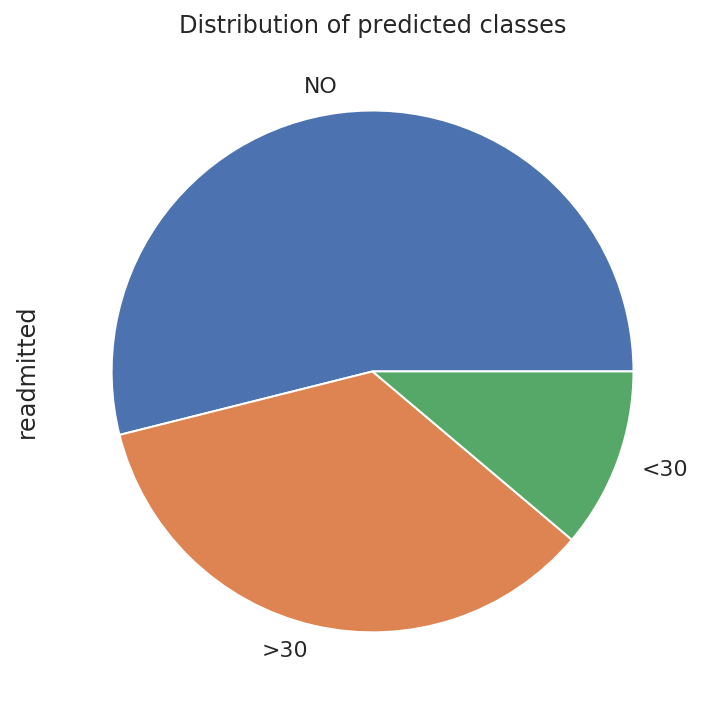

In [12]:
df.readmitted.value_counts().plot(kind='pie', title='Distribution of predicted classes');

In [13]:
df.readmitted.value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

### Missing values

From first view of the data, we could see that there are also missing values. We could see also some rows with *None* values, but those values mean that measurement was not done (according to paper that published this dataset). In those cases, *None* value does not represent missing value - information about not performing the measurement can be helpful when predicting patient readmission.

Let's check which columns have missing values and how many (the bar represents the fraction of data that are available - lower the bar, the more missing values are there):

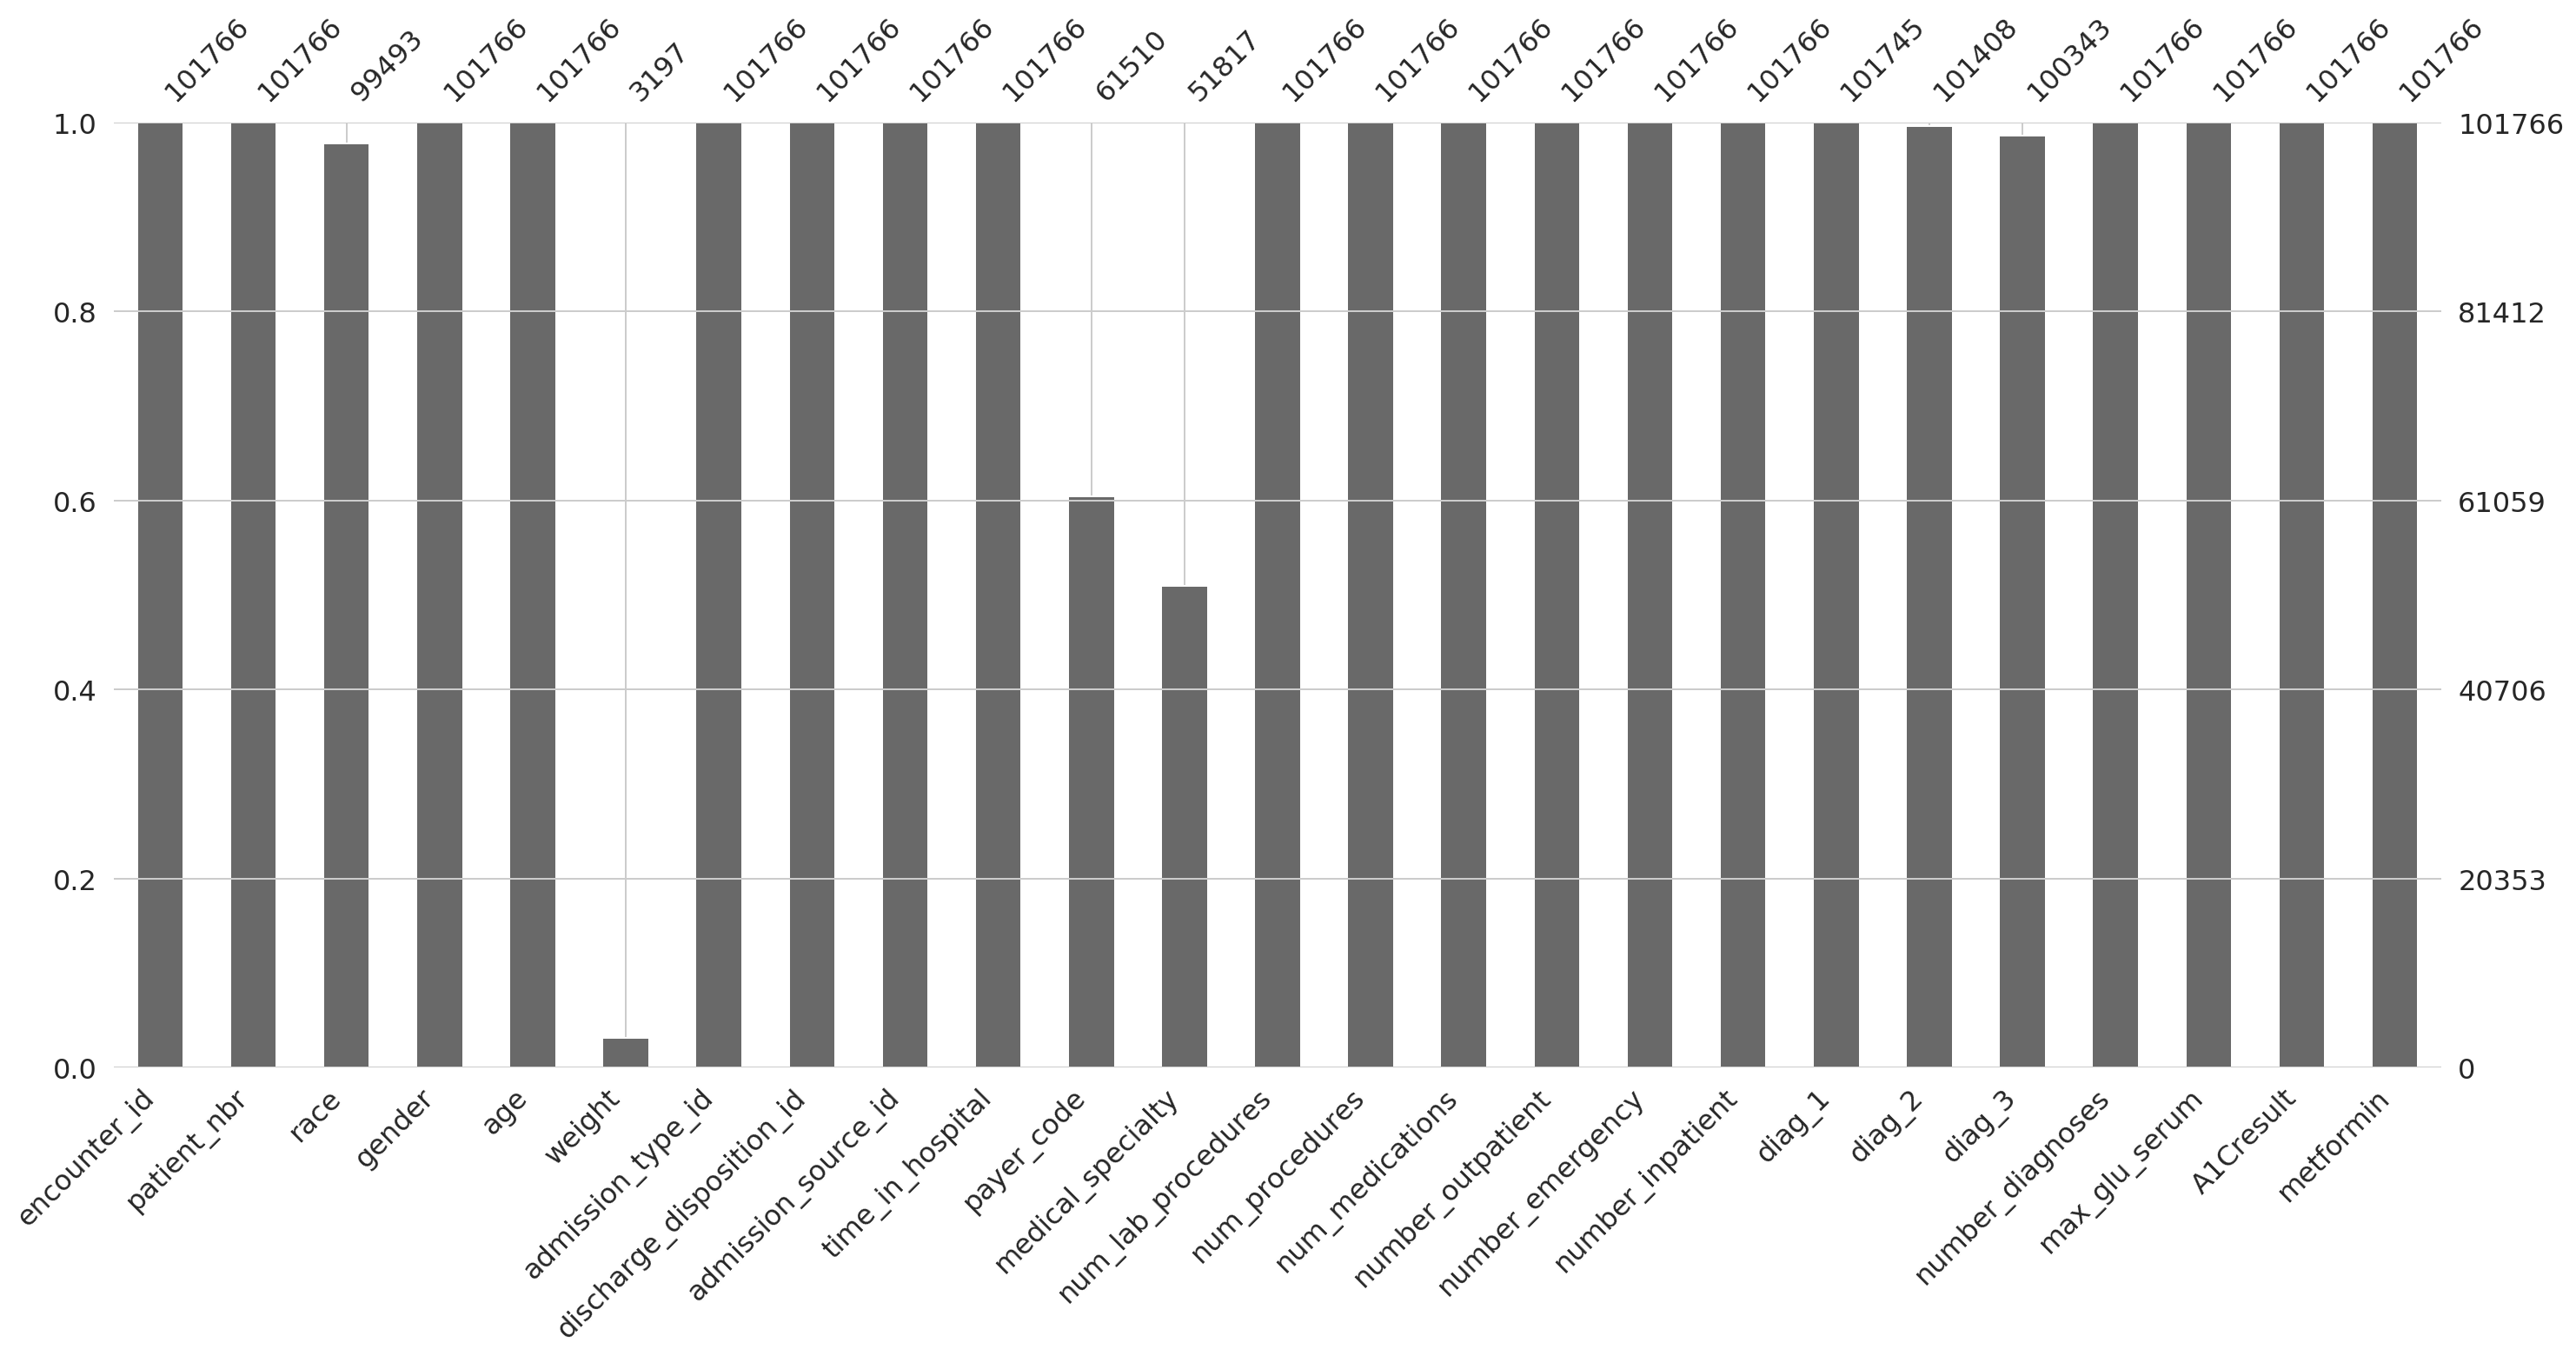

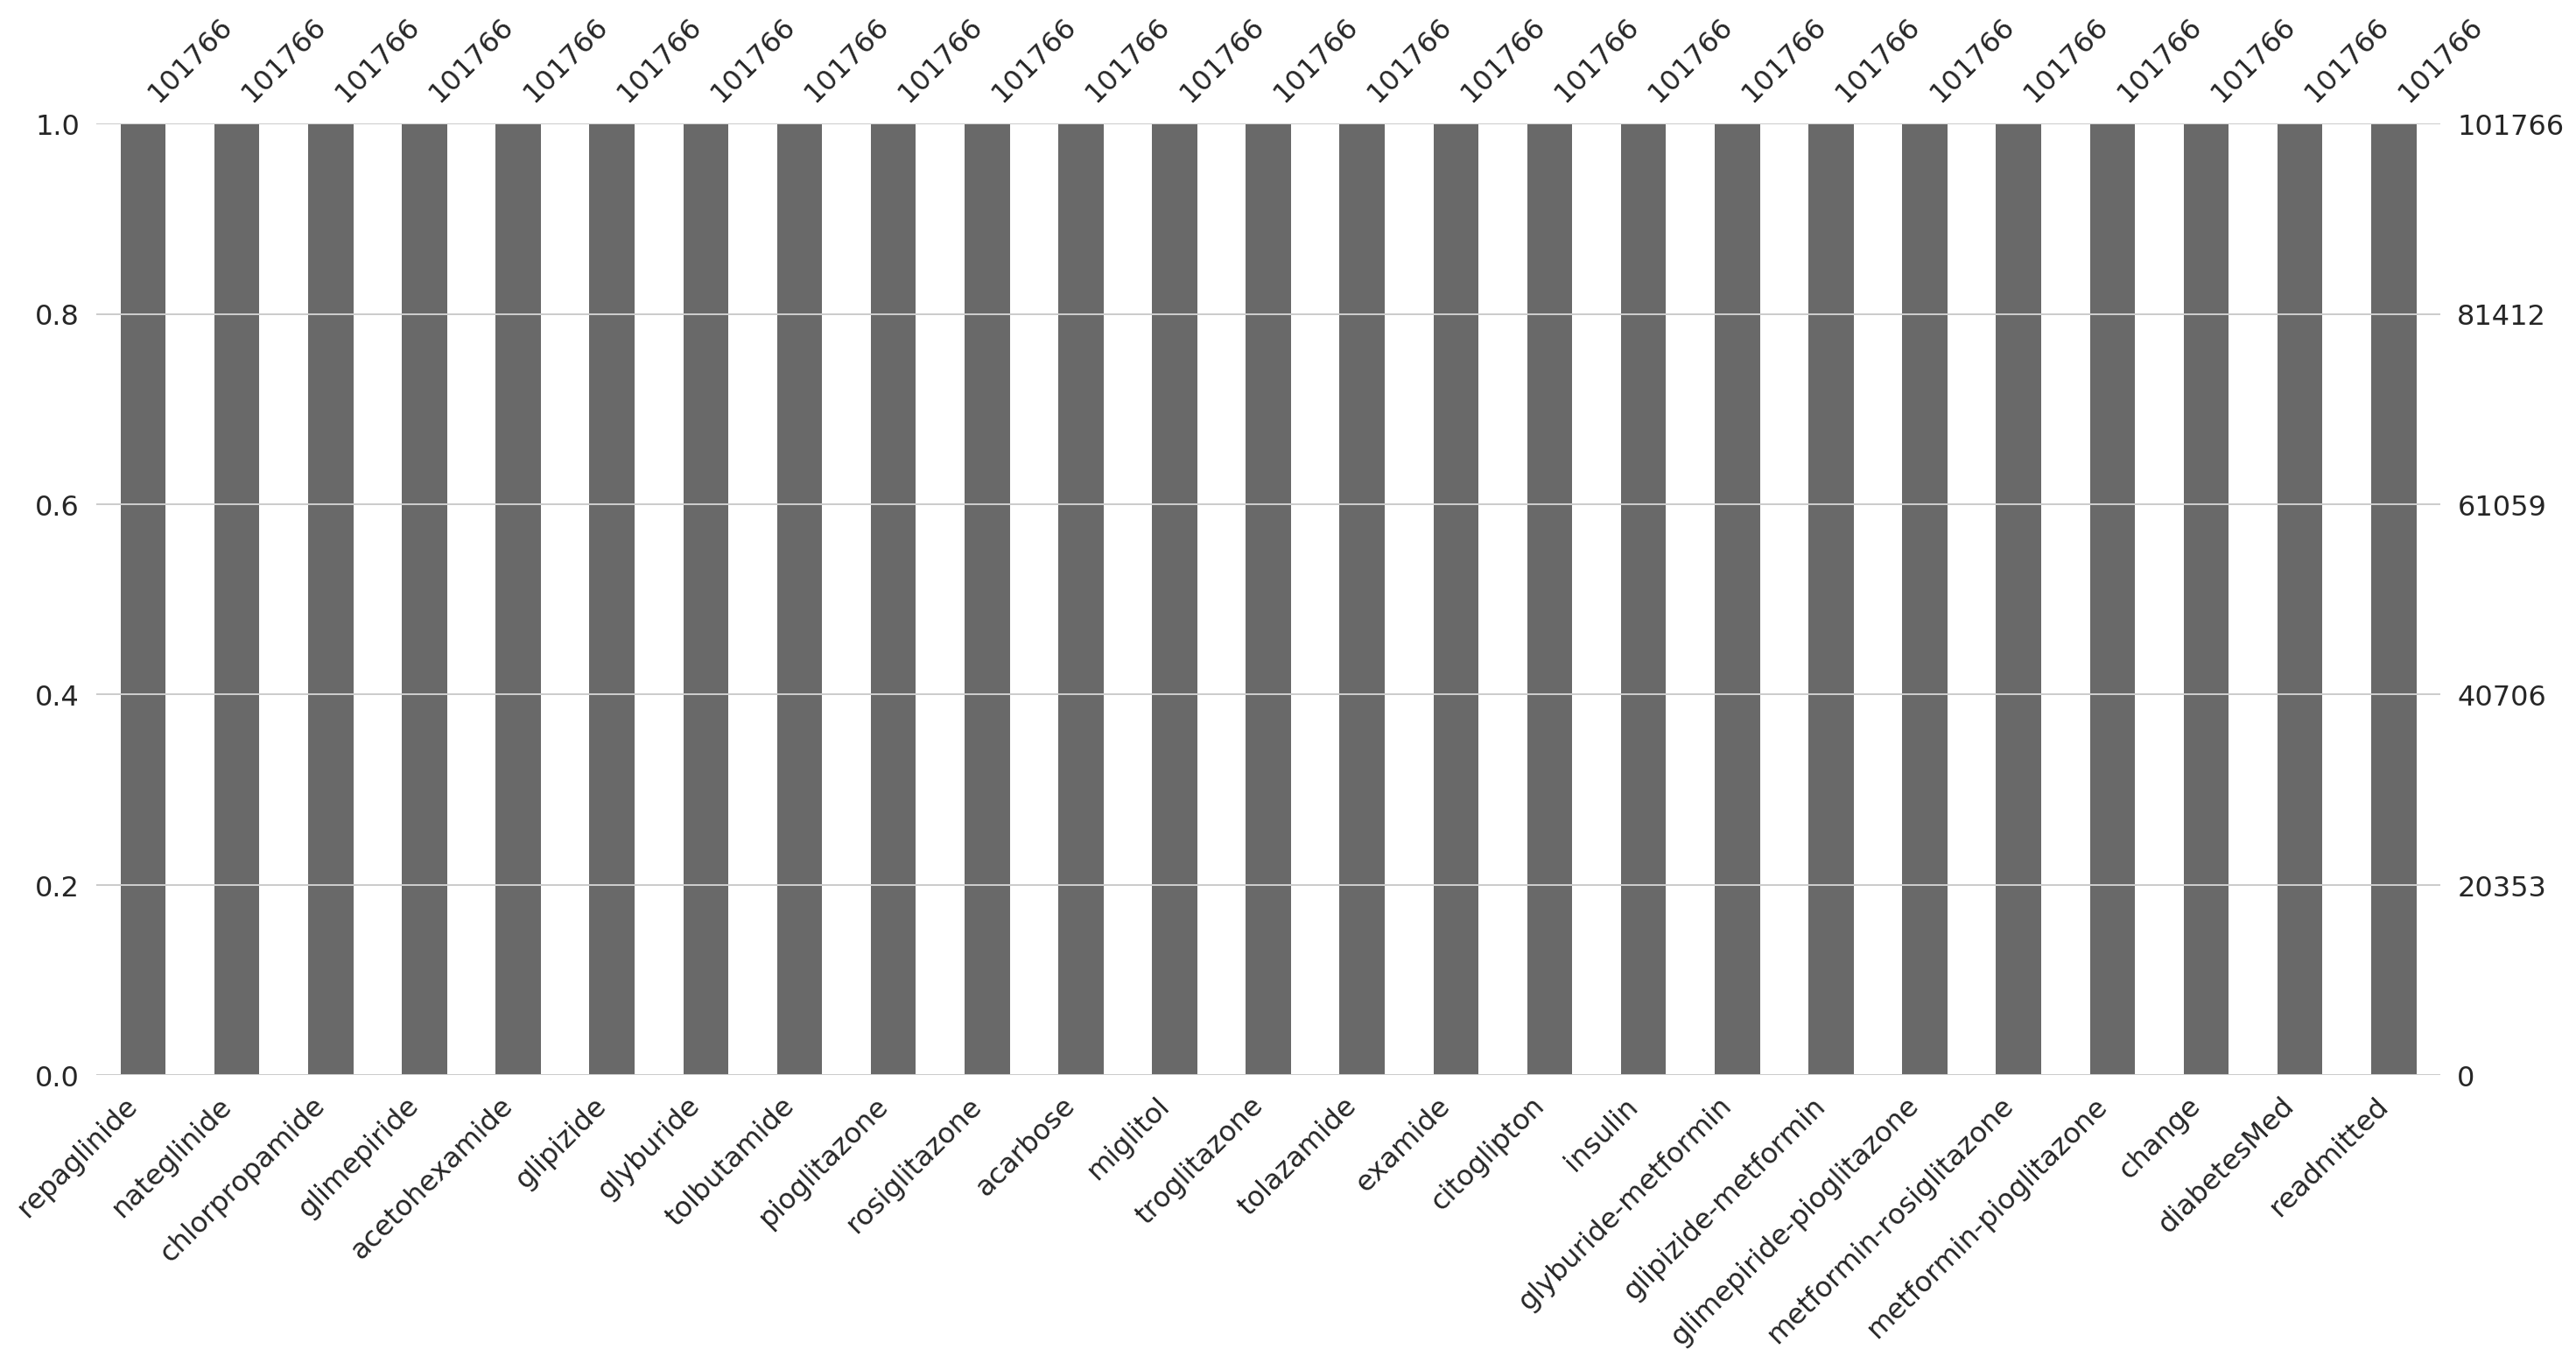

In [14]:
# Divide columns to 2 groups (too many columns for one plot)
column_groups = np.array_split(df.columns, 2)

for columns in column_groups:
    msno.bar(df[columns])
    plt.show()

### Attributes analysis

In this section, we will analyse all meaningful attributes one by one.

#### Functions definitions

In [15]:
df[df.weight.isnull()]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),NaN,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),NaN,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),NaN,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),NaN,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO


In [273]:
def missing_values(df, attribute):
    """
    Check number of missing values in selected attribute.
    
    :param df: dataframe with data.
    :param attribute: name of attribute to check missing values.
    """
    num_missing = len(df[df[attribute].isnull()])
    missing_percentage = round(num_missing / len(df) * 100, 2)
    print(f'Number of missing values: {num_missing} ({missing_percentage}%)')


def barplot_per_classes(df, attribute, groupby, title=None, ticks_rotation=0, topn=-1, ax=None):
    """
    Draw barplot of attribute per each class.
    
    :param df: dataframe with data to be drawn on barplot.
    :param attribute: name of attribute to be drawn on barplot.
    :param groupby: name of attribute with predicted classes.
    :param title: title of plot.
    :param ticks_rotation: rotation of x-ticks (labels).
    """
    uniq_values = df[attribute].value_counts().head(topn).index
    df = df[df[attribute].isin(uniq_values)]
    data = df.groupby(groupby)[attribute].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
    
    sns.barplot(attribute, 'percentage', hue=groupby, data=data, ax=ax)
    plt.xticks(rotation=ticks_rotation)
    plt.title(title)
    plt.legend(loc='upper right')

    
def kdeplot_per_classes(df, attribute, groupby, title=None, rotation=0, ax=None):
    """
    Draw kdeplot of attribute per each class.
    
    :param df: dataframe with data to be drawn on kdeplot.
    :param attribute: name of attribute to be drawn on kdeplot.
    :param groupby: name of attribute with predicted classes.
    :param title: title of plot.
    :param ticks_rotation: rotation of x-ticks (labels).
    """
    for x in df[groupby].unique():
        sns.kdeplot(df[df[groupby] == x][attribute], label=x, shade=True, shade_lowest=False, ax=ax)
    plt.title(title)
    plt.xticks(rotation=rotation)
    
def boxplot_per_classes(df, attribute, groupby, title=None, rotation=0, ax=None):
    """
    Draw boxplot of attribute per each class.
    
    :param df: dataframe with data to be drawn on kdeplot.
    :param attribute: name of attribute to be drawn on kdeplot.
    :param groupby: name of attribute with predicted classes.
    :param title: title of plot.
    :param ticks_rotation: rotation of x-ticks (labels).
    """
    sns.boxplot(x=groupby, y=attribute, data=df, ax=ax)
    plt.title(title)
    plt.xticks(rotation=rotation)

In [17]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

There are also some attributes that are not meaningful for our prediction (like `encounter_id` or `patient_nbr`). These attributes will not be analysed.

## TODO
- only attibutes that has missing values will print concrete values with `missing_values` function
- add simple description of each attribute according to paper
- boxplots for numerical attributes

#### race

In [18]:
missing_values(df, 'race')

Number of missing values: 2273 (2.23%)


In [19]:
df.race.value_counts()

Caucasian          76099
AfricanAmerican    19210
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

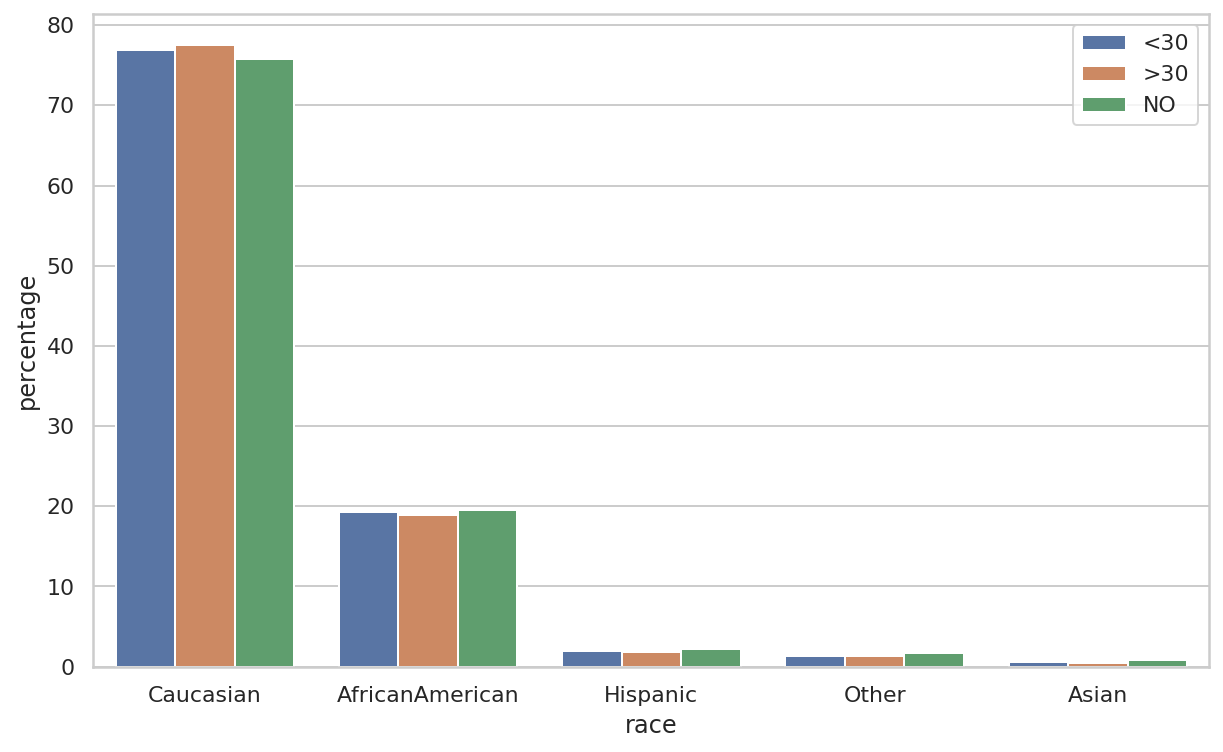

In [20]:
barplot_per_classes(df, 'race', 'readmitted')

#### gender

In [21]:
df.gender.value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

TODO - 3 values should be changed to male/female (like setting NaN value)

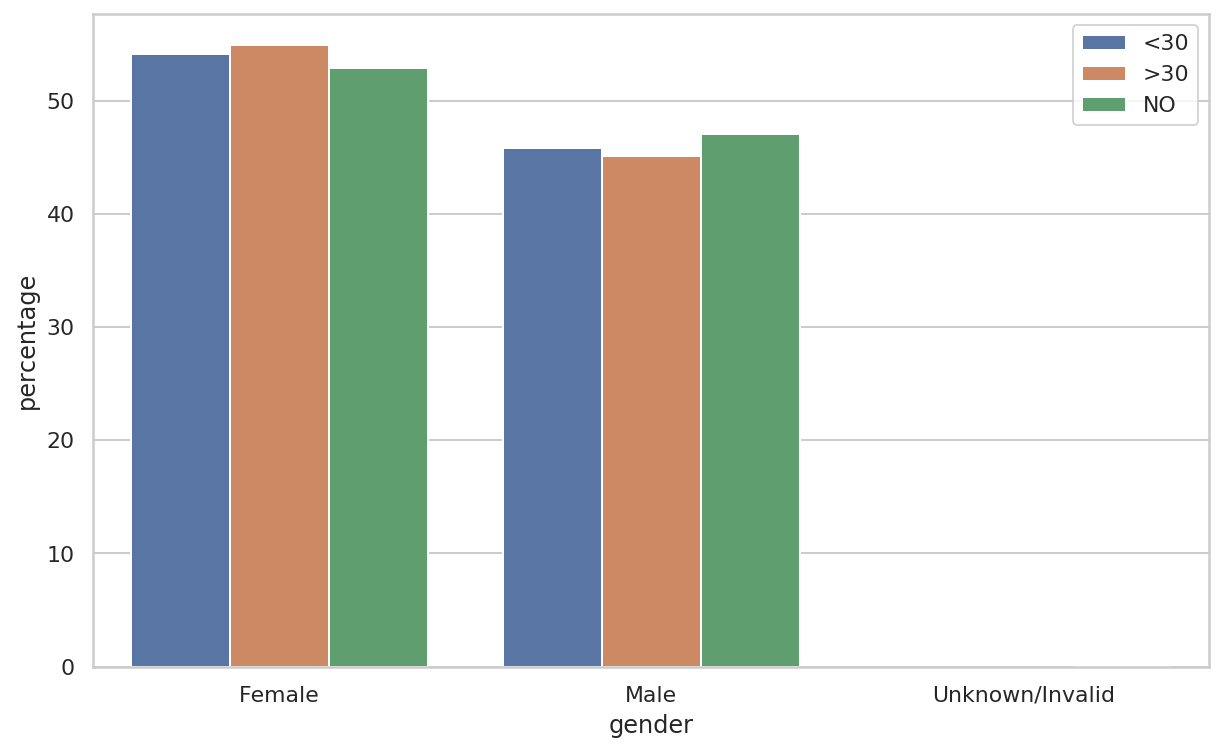

In [22]:
barplot_per_classes(df, 'gender', 'readmitted')

#### age

In [23]:
df.age.value_counts()

[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64

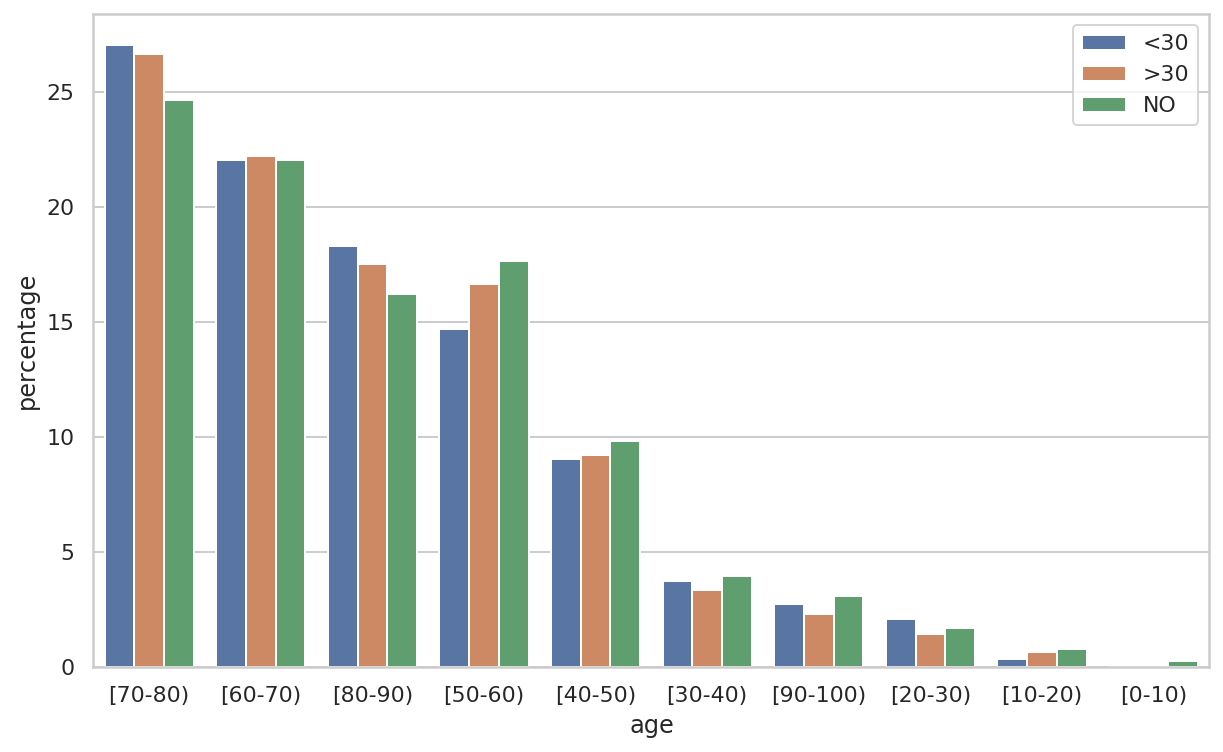

In [24]:
barplot_per_classes(df, 'age', 'readmitted')

#### weight

In [25]:
missing_values(df, 'weight')

Number of missing values: 98569 (96.86%)


TODO - maybe drop col (too much missing values)

In [26]:
df.weight.value_counts()

[75-100)     1336
[50-75)       897
[100-125)     625
[125-150)     145
[25-50)        97
[0-25)         48
[150-175)      35
[175-200)      11
>200            3
Name: weight, dtype: int64

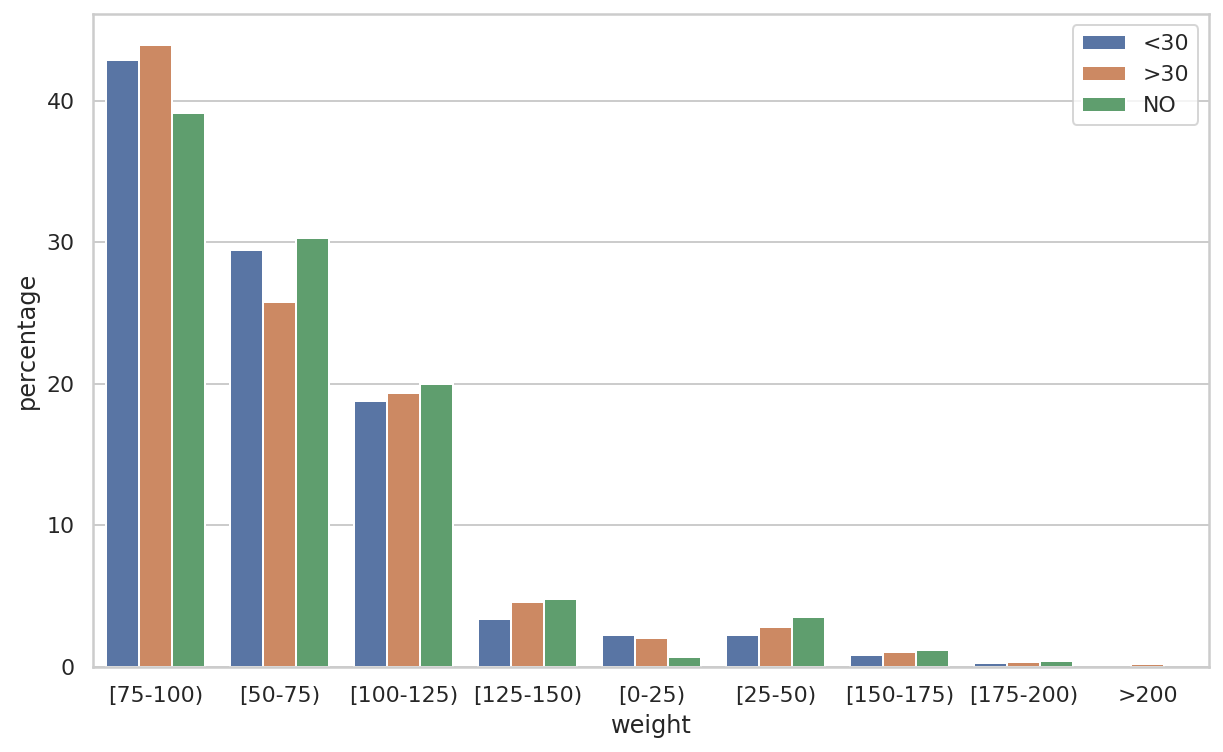

In [27]:
barplot_per_classes(df, 'weight', 'readmitted')

#### admission_type_id

In [28]:
df.admission_type_id.value_counts()

1    53990
3    18869
2    18480
6     5291
5     4785
8      320
7       21
4       10
Name: admission_type_id, dtype: int64

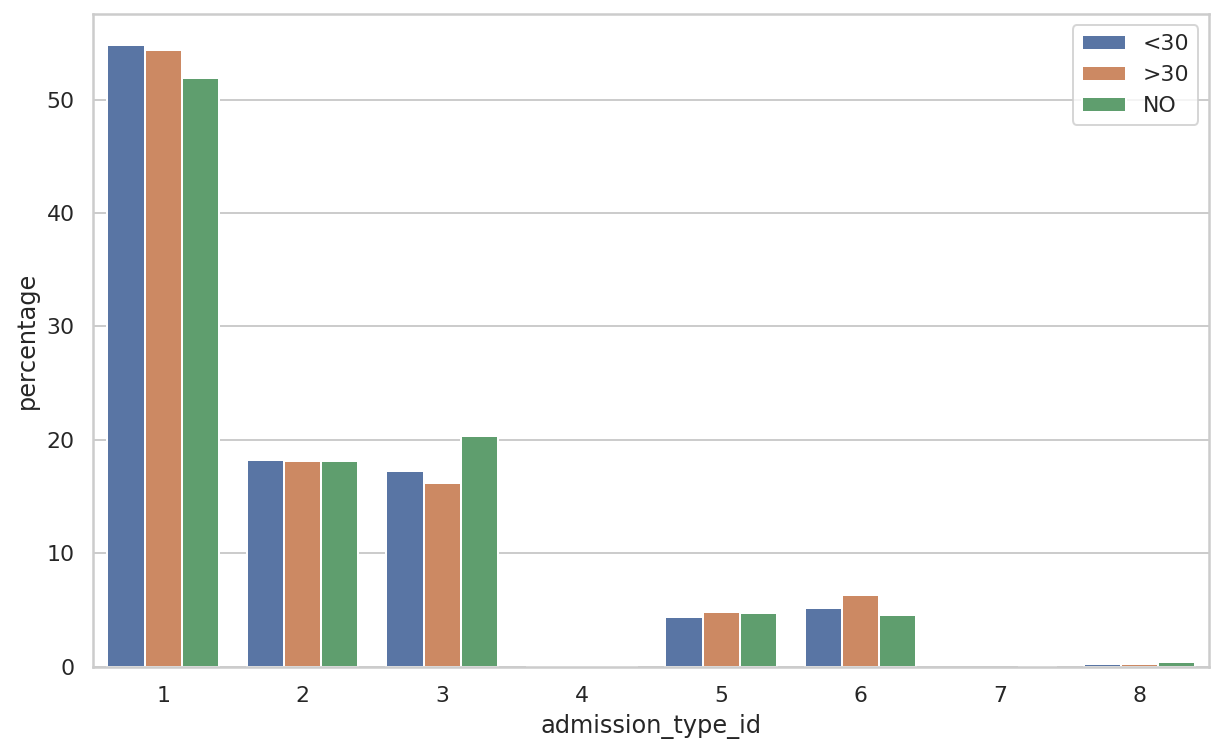

In [29]:
barplot_per_classes(df, 'admission_type_id', 'readmitted')

#### discharge_disposition_id

In [30]:
df.discharge_disposition_id.value_counts()

1     60234
3     13954
6     12902
18     3691
2      2128
22     1993
11     1642
5      1184
25      989
4       815
7       623
23      412
13      399
14      372
28      139
8       108
15       63
24       48
9        21
17       14
16       11
19        8
10        6
27        5
12        3
20        2
Name: discharge_disposition_id, dtype: int64

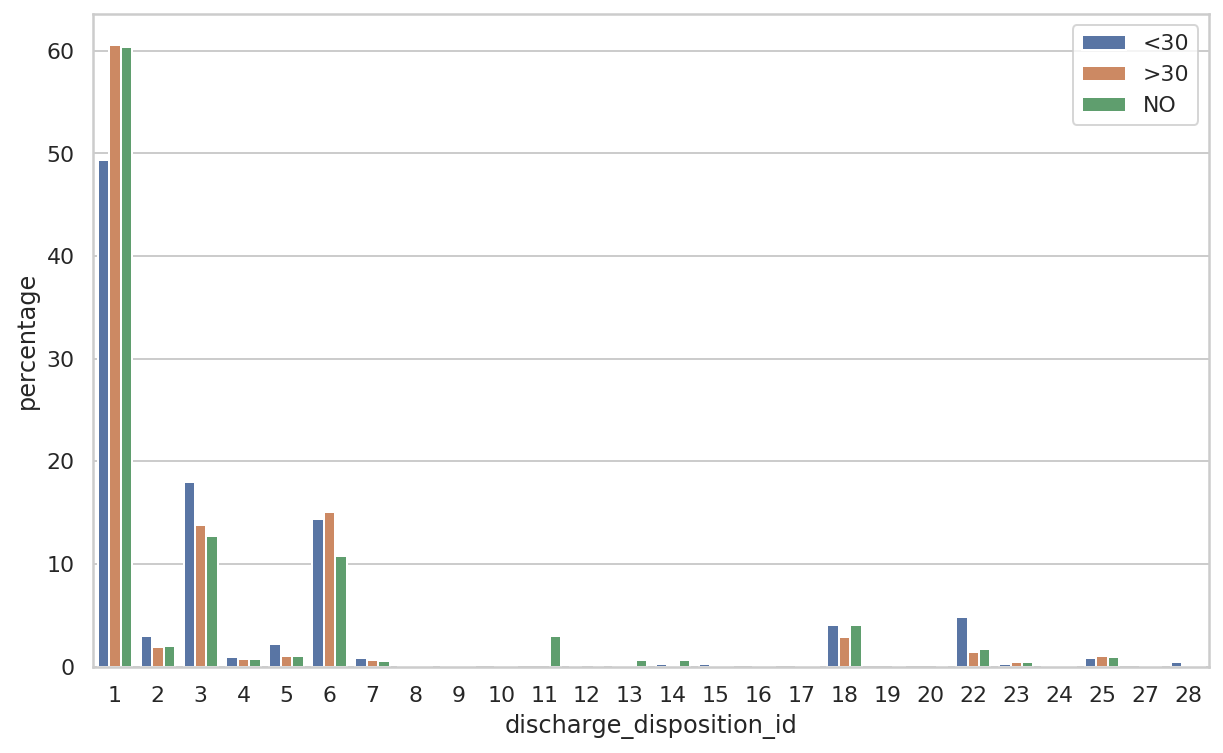

In [31]:
barplot_per_classes(df, 'discharge_disposition_id', 'readmitted')

#### admission_source_id

In [32]:
df.admission_source_id.value_counts()

7     57494
1     29565
17     6781
4      3187
6      2264
2      1104
5       855
3       187
20      161
9       125
8        16
22       12
10        8
11        2
14        2
25        2
13        1
Name: admission_source_id, dtype: int64

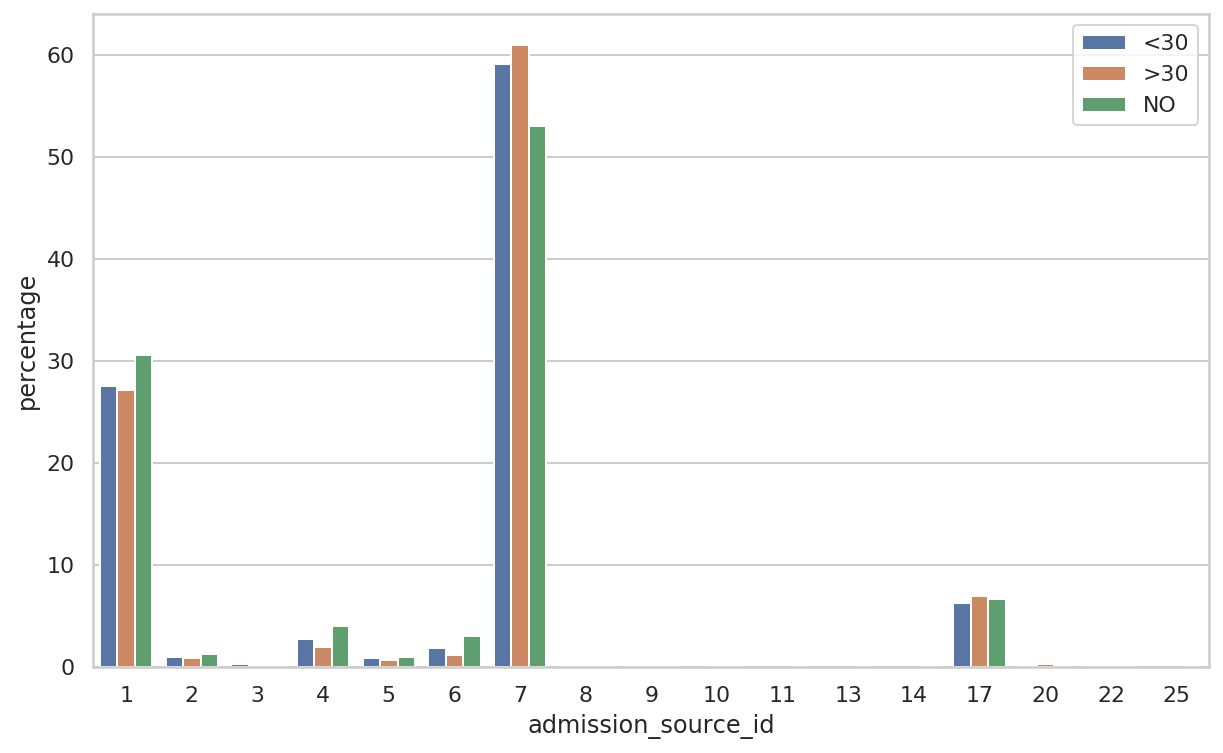

In [33]:
barplot_per_classes(df, 'admission_source_id', 'readmitted')

#### time_in_hospital

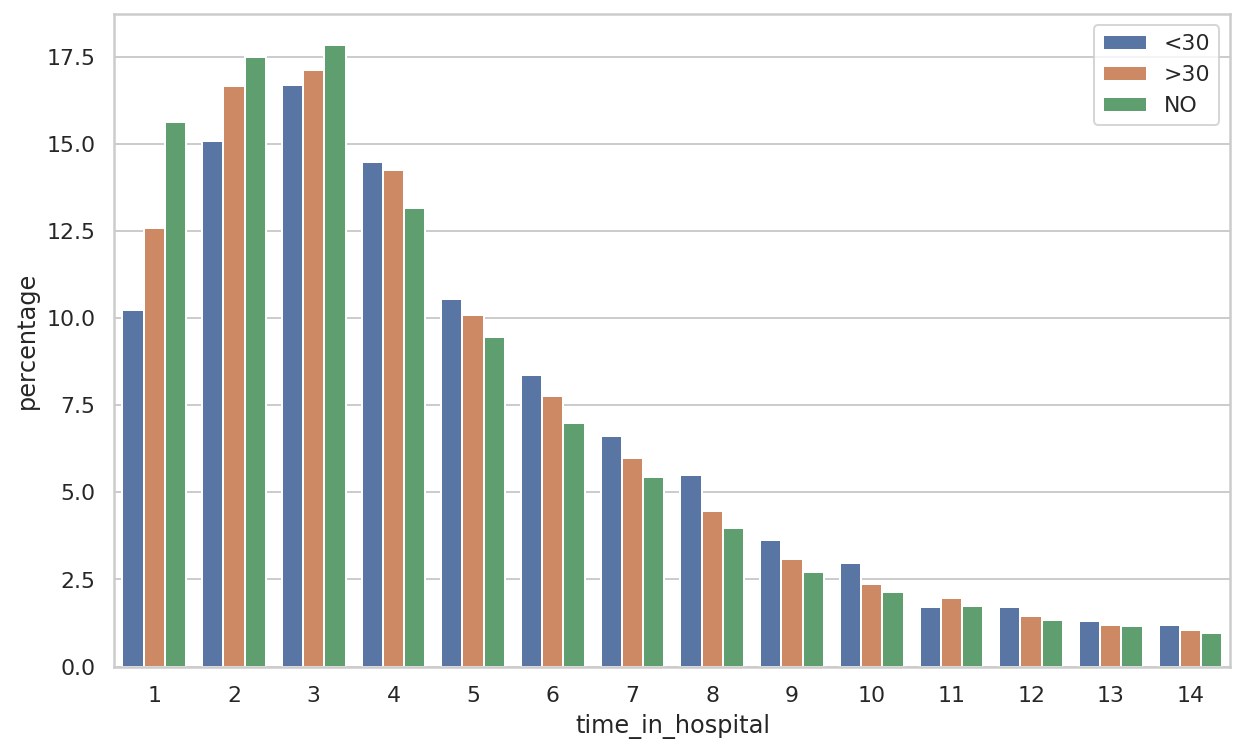

In [36]:
barplot_per_classes(df, 'time_in_hospital', 'readmitted')

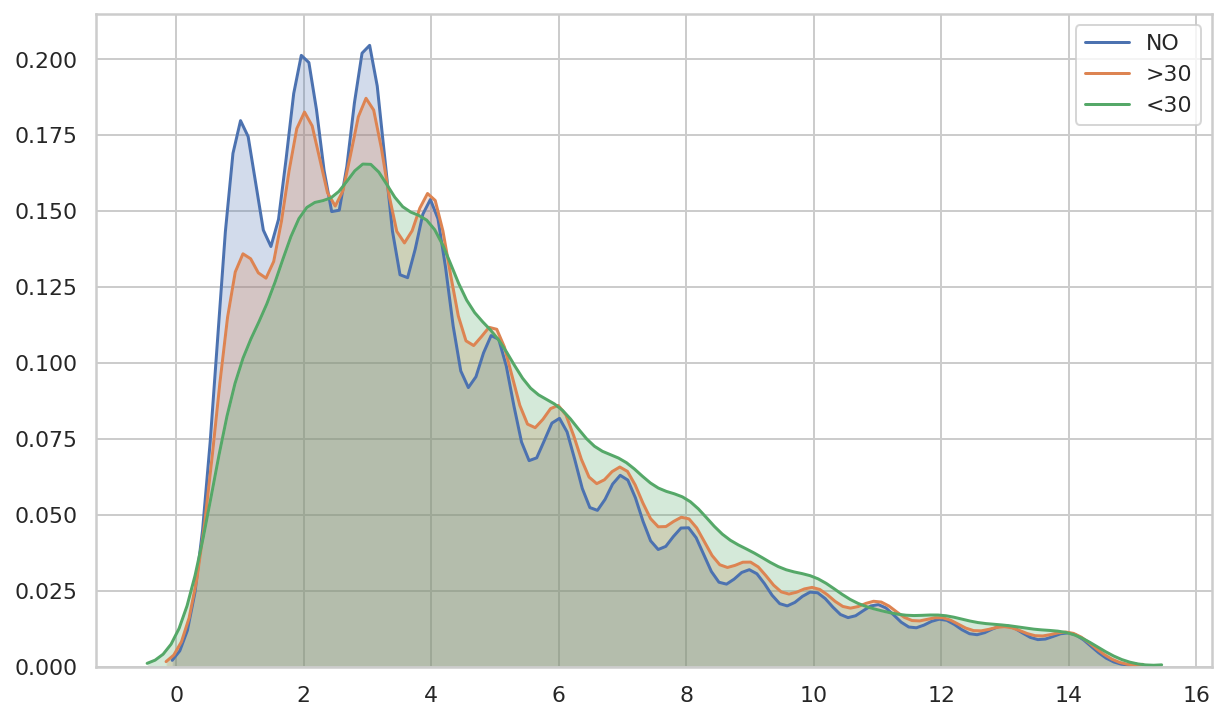

In [83]:
kdeplot_per_classes(df, 'time_in_hospital', 'readmitted')

#### payer_code

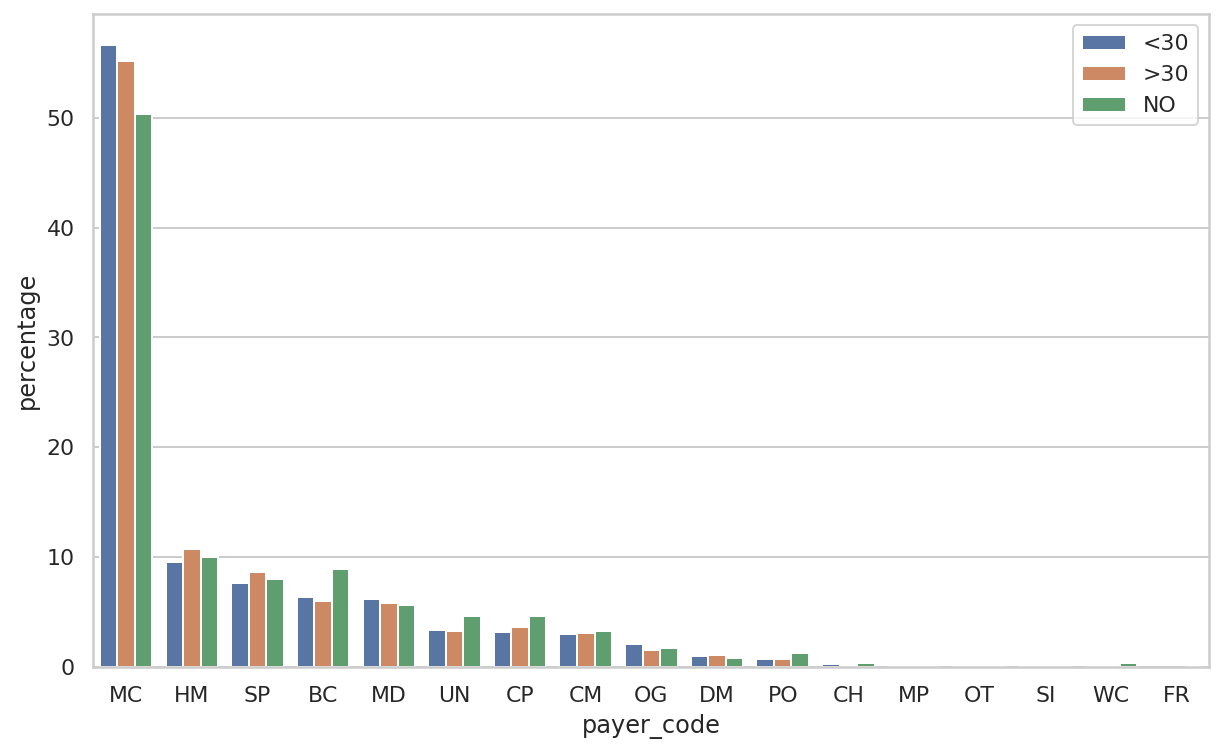

In [44]:
barplot_per_classes(df, 'payer_code', 'readmitted')

#### medical_specialty

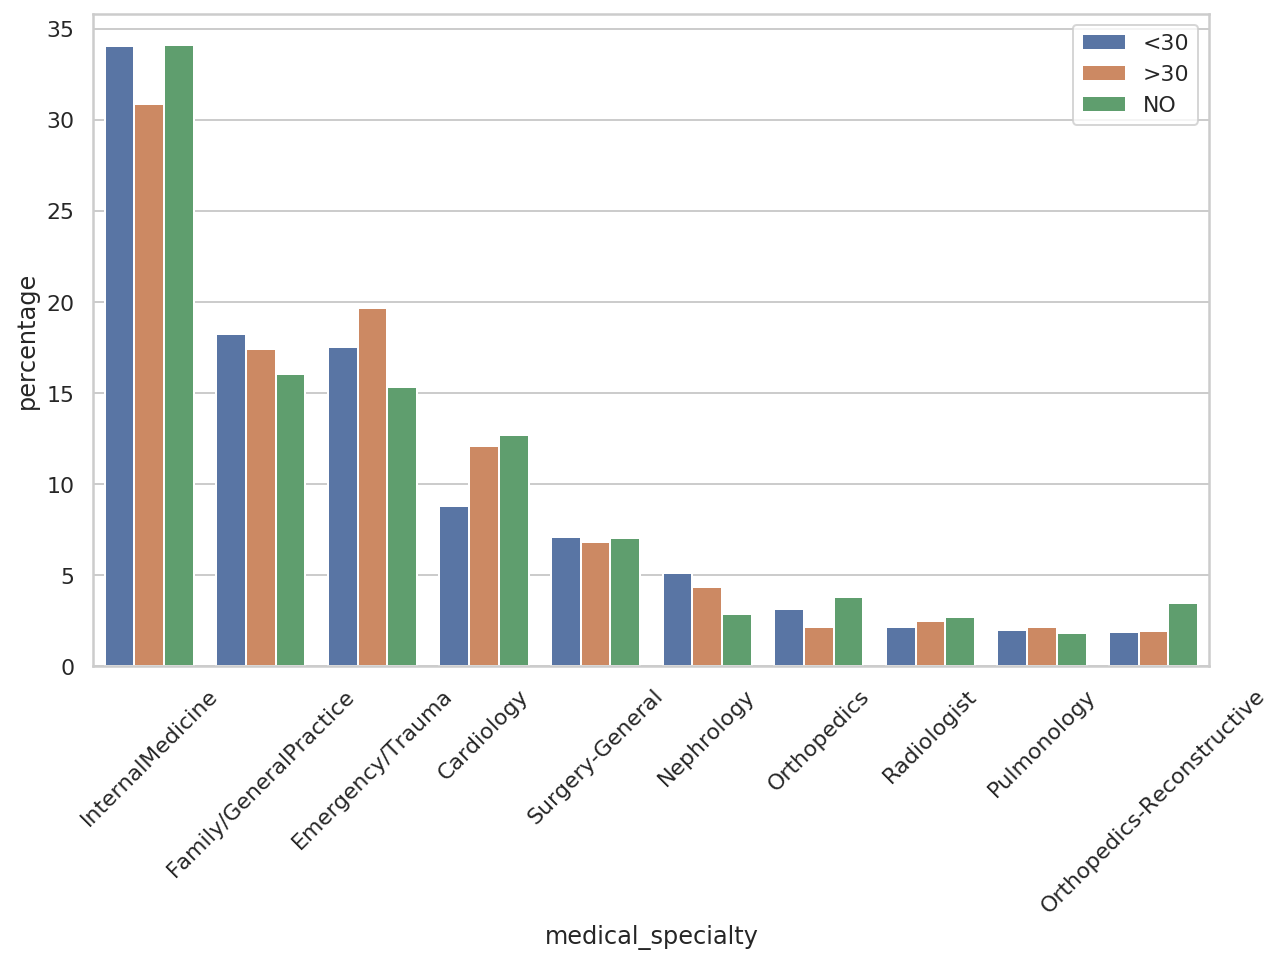

In [75]:
barplot_per_classes(df, 'medical_specialty', 'readmitted', ticks_rotation=45 ,topn=10)

#### num_lab_procedures
Number of lab tests performed during the encounter

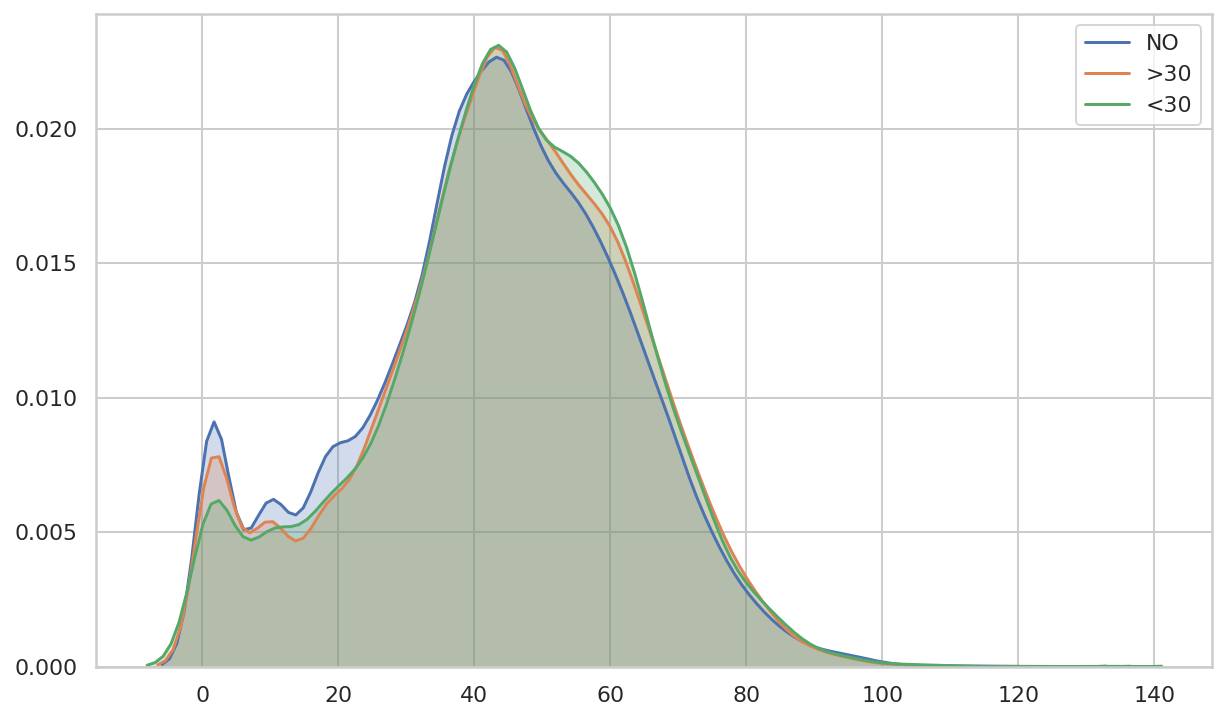

In [82]:
kdeplot_per_classes(df, 'num_lab_procedures', 'readmitted')

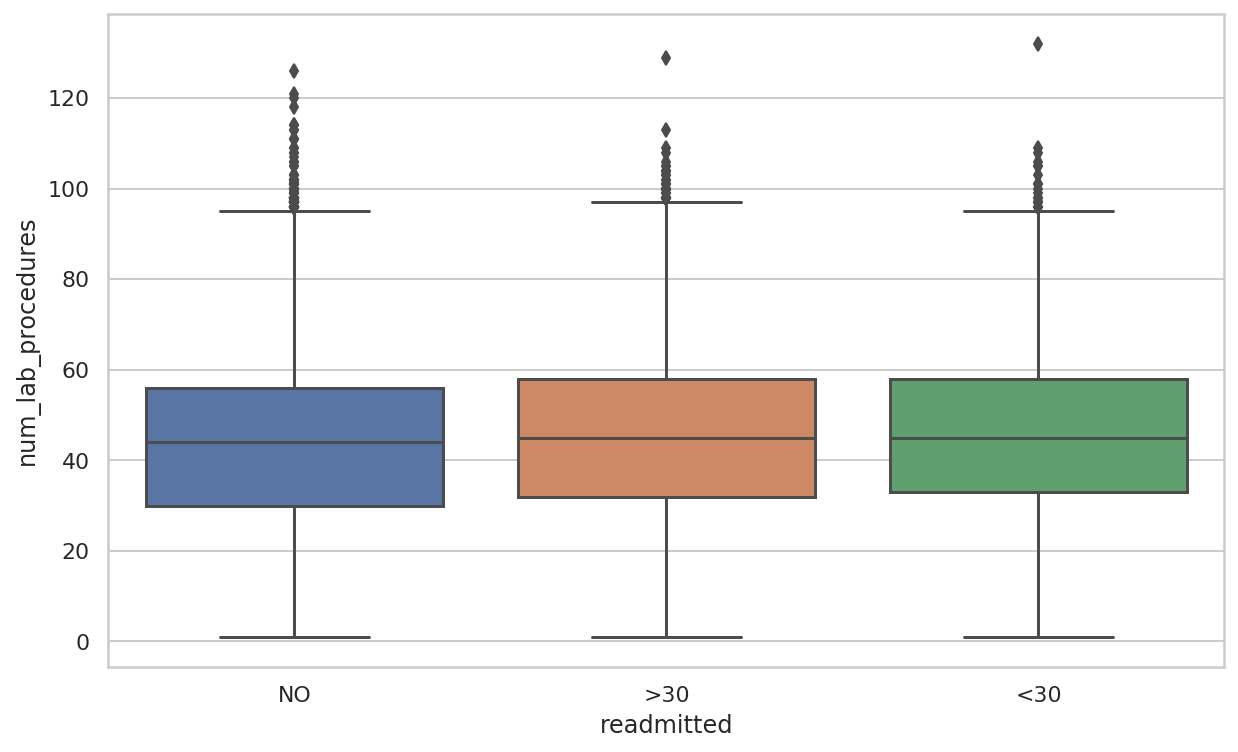

In [81]:
boxplot_per_classes(df, 'num_lab_procedures', 'readmitted')

#### num_procedures
Number of procedures (other than lab tests) performed during the encounter

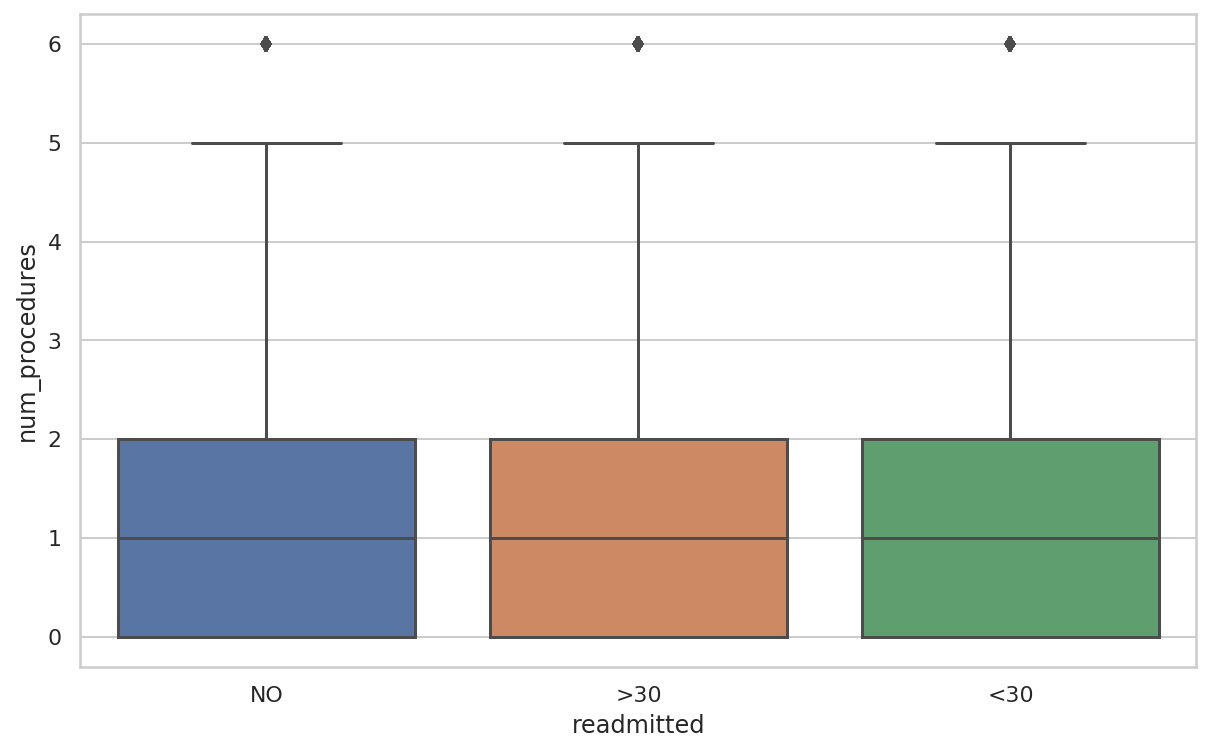

In [84]:
boxplot_per_classes(df, 'num_procedures', 'readmitted')

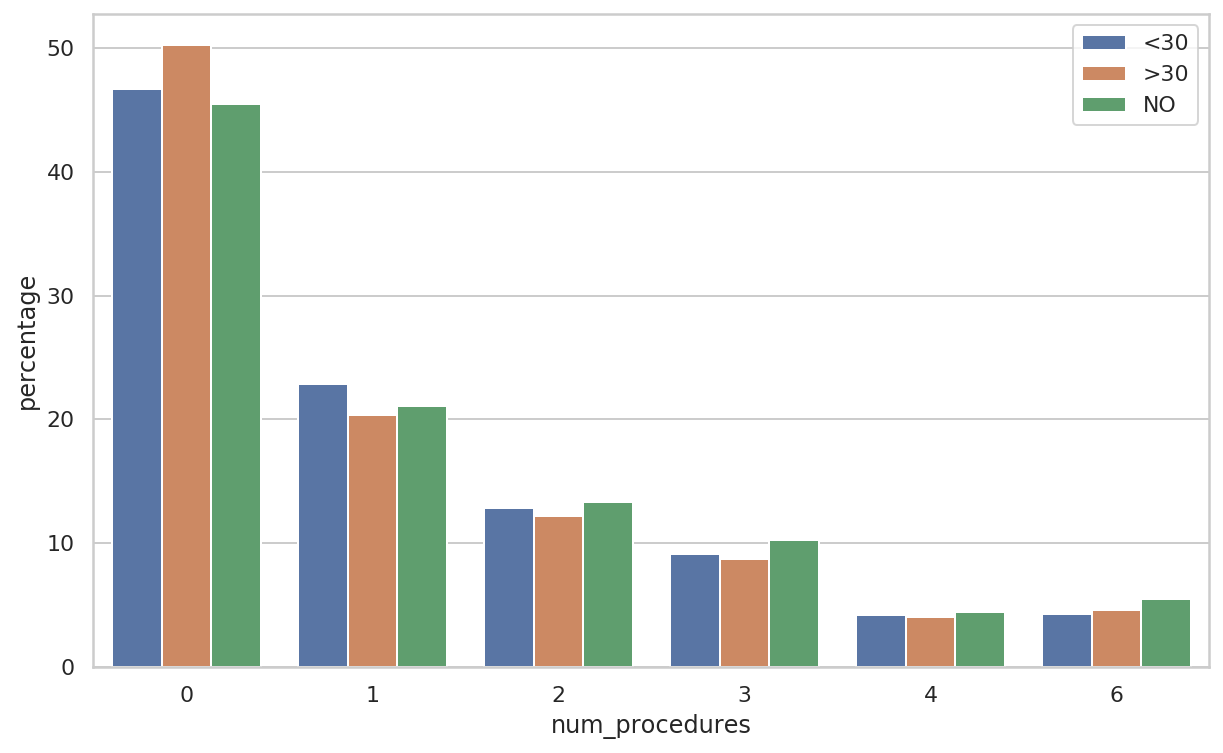

In [87]:
barplot_per_classes(df, 'num_procedures', 'readmitted')

#### num_medications
Number of distinct generic names administered during the encounter

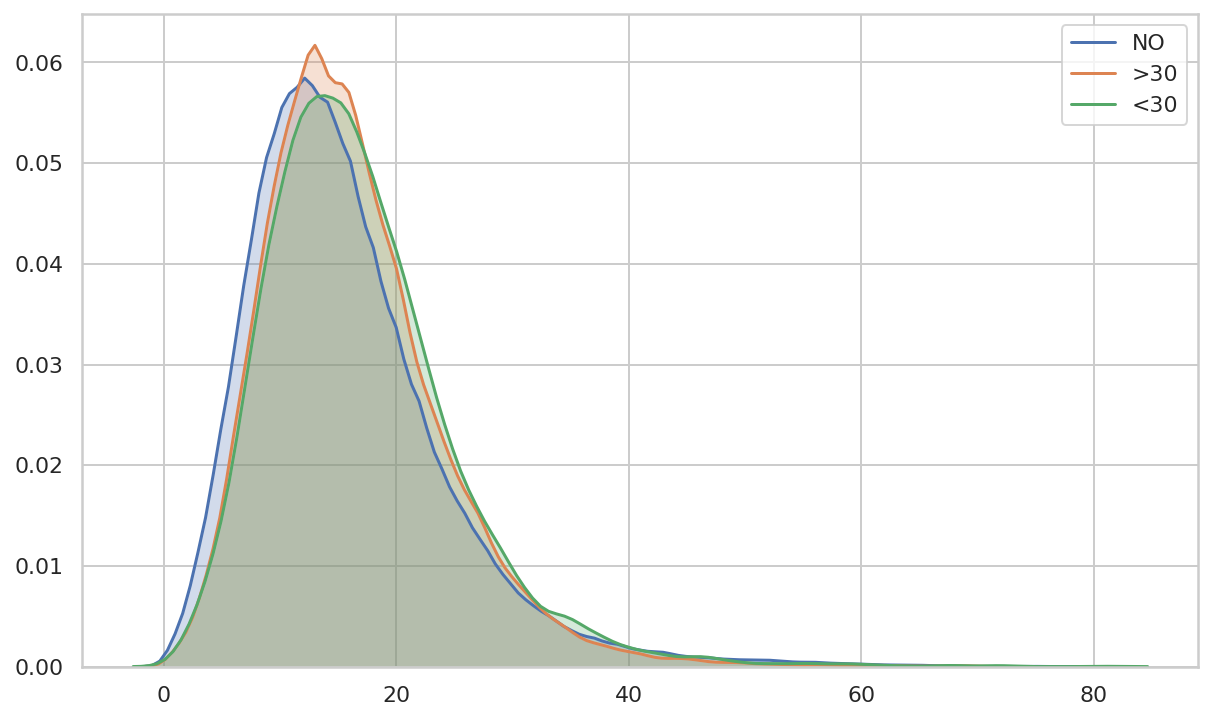

In [276]:
kdeplot_per_classes(df, 'num_medications', 'readmitted')

#### number_outpatient
Number of outpatient visits of the patient in the year preceding the encounter

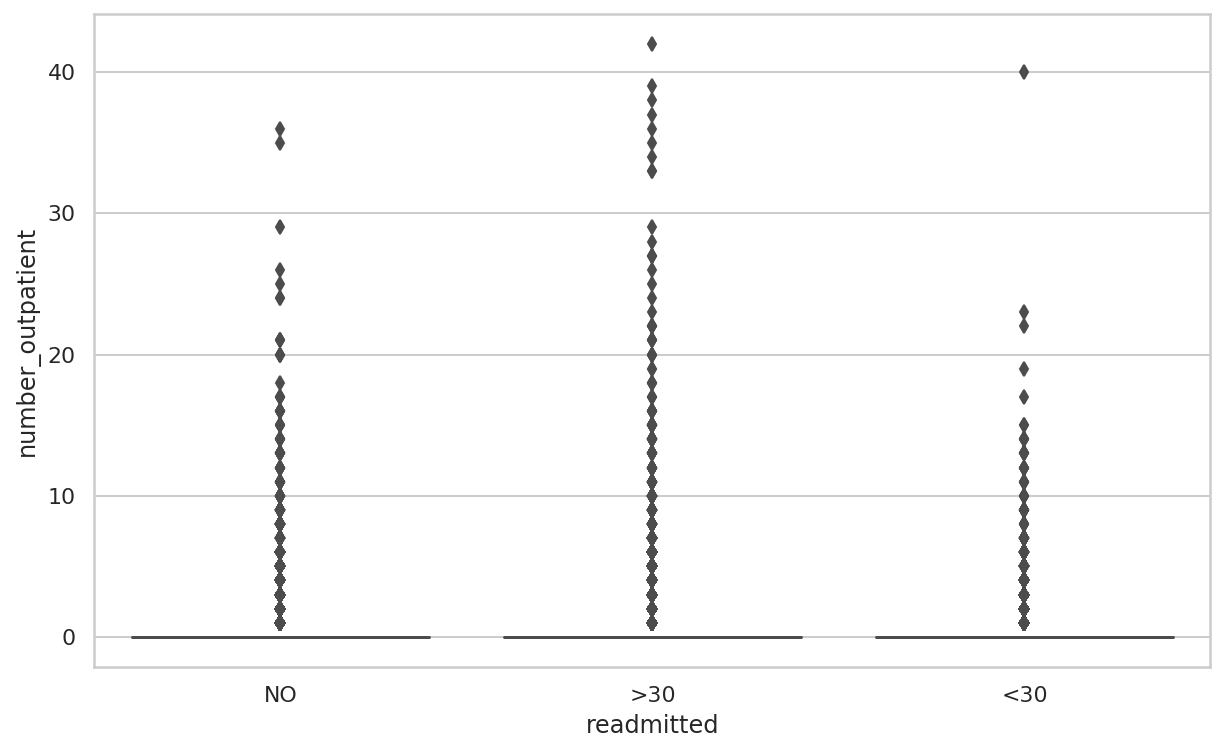

In [94]:
boxplot_per_classes(df, 'number_outpatient', 'readmitted')

#### number_emergency
Number of emergency visits of the patient in the year preceding the encounter

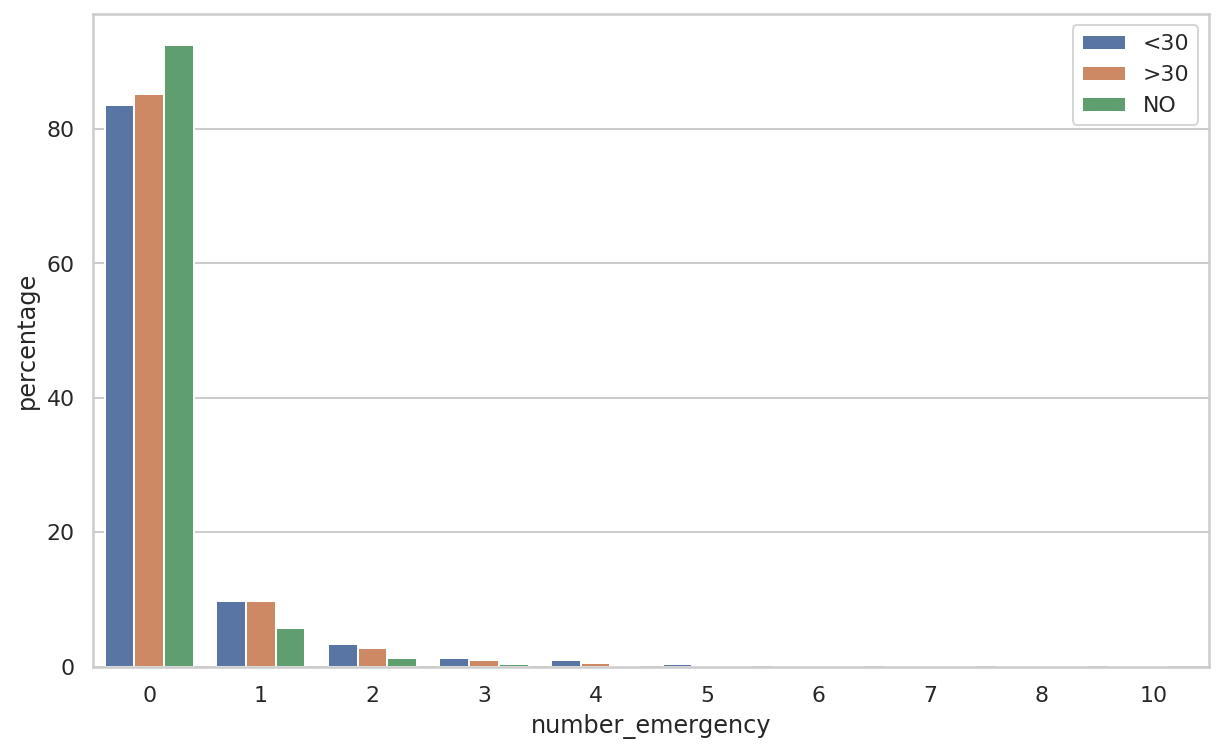

In [99]:
barplot_per_classes(df, 'number_emergency', 'readmitted', topn=10)

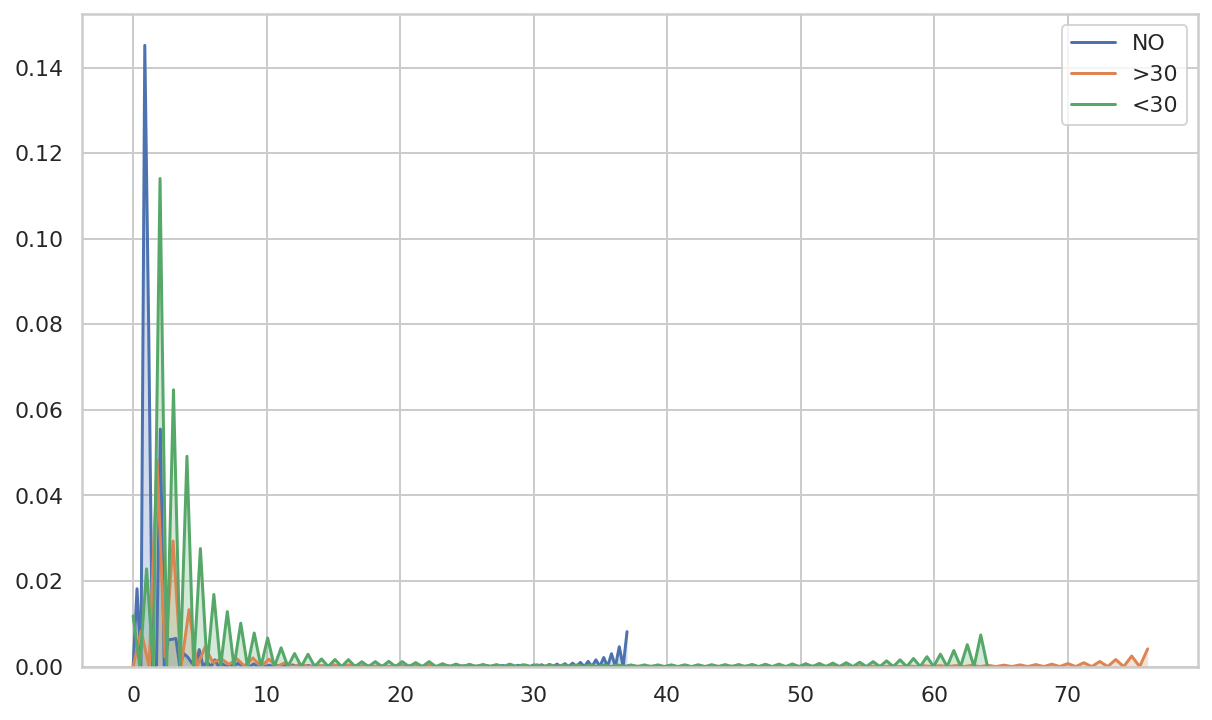

In [275]:
kdeplot_per_classes(df, 'number_emergency', 'readmitted')

#### number_inpatient
Number of inpatient visits of the patient in the year preceding the encounter

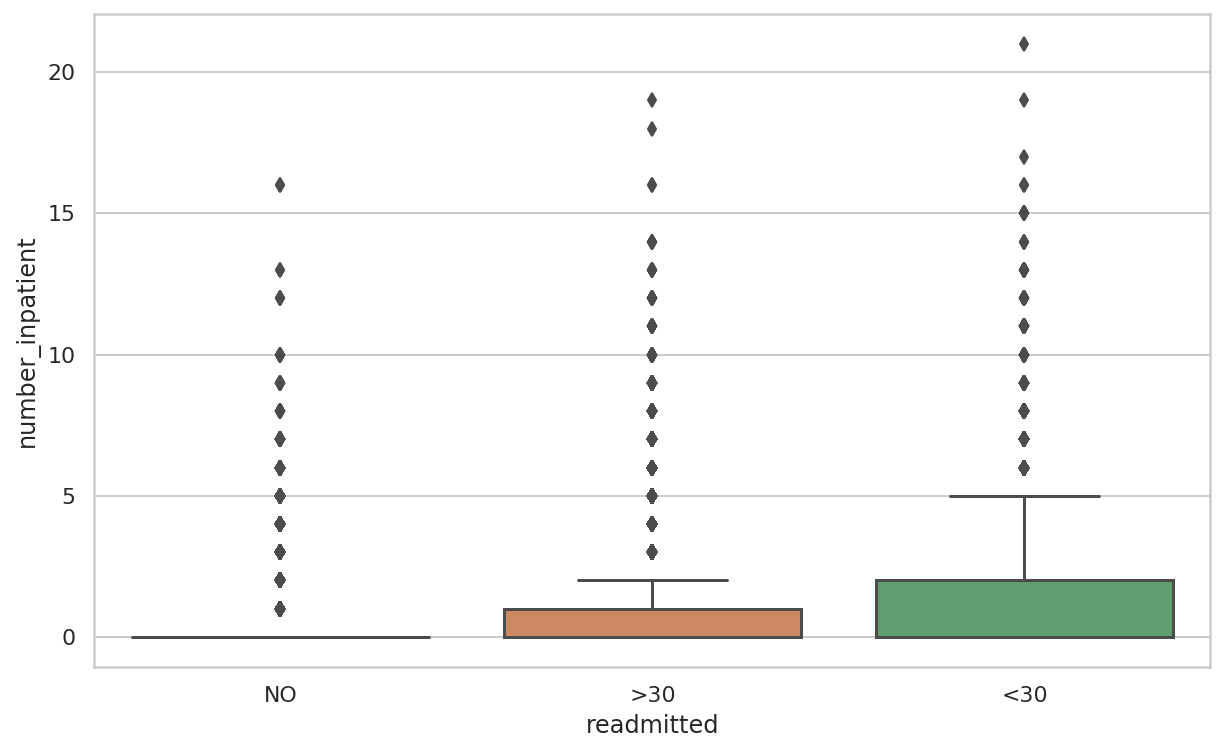

In [102]:
boxplot_per_classes(df, 'number_inpatient', 'readmitted')

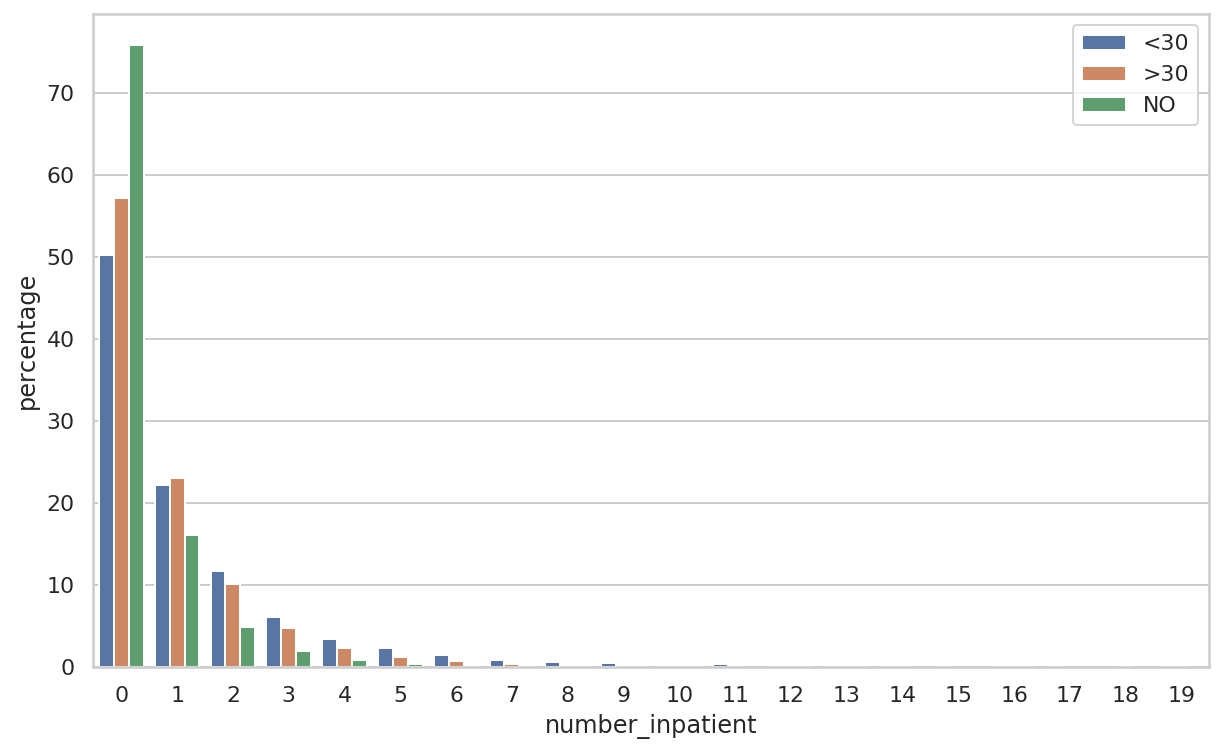

In [104]:
barplot_per_classes(df, 'number_inpatient', 'readmitted')

### diagnosis
Columns **diag_1**, **diag_2** and **diag_3** are codes for one of the type of diagnose. Here we need create mapping where diagnosis code is mapped to categorical value. We used rules from paper to map more than 700 unique code values to 9 gorups of diagnosis.

In [231]:
df['diag_1'].unique().shape

(717,)

In [232]:
def diagnosis_mapping():
#     list(range(790,800)) + [780, 781, 784, 782] + list(range(240,250) + list(range(251,280) + list(range(680,710)) + list(range(1,140))
    mapping = {}
    mapping['circulatory'] = list(range(390,460)) + [785]
    mapping['respiratory'] = list(range(460,520)) + [786]
    mapping['digestive'] = list(range(520,580)) + [787]
    mapping['diabetes'] = [250]
    mapping['injury'] = list(range(800,1000))
    mapping['musculoskeletal'] = list(range(710,740))
    mapping['genitourinary'] = list(range(580,630)) + [788]
    mapping['neoplasm'] = list(range(140,240))
    all_codes =  reduce(lambda x,y: x + mapping[y] ,mapping.keys(), [])
    mapping['other'] = [x for x in range(1,1000) if x not in all_codes]
    for key in mapping.keys():
        mapping[key] = [str(x) for x in mapping[key]]
    mapping['other'] = mapping['other'] + list(string.ascii_uppercase)
    return mapping

In [233]:
def map_code_to_diagnose(code, mapping):
    code = str(code)
    if not code:
        return None
    for diagnose in mapping.keys():
        if diagnose in ['diabetes', 'other']:
            if any([code.startswith(x) for x in mapping[diagnose]]):
                return diagnose
            else:
                continue
        if code in mapping[diagnose]:
            return diagnose
        
    

In [235]:
mapping = diagnosis_mapping()
df['diag_1_category'] = df['diag_1'].apply(lambda x: map_code_to_diagnose(x, mapping))
df['diag_2_category'] = df['diag_2'].apply(lambda x: map_code_to_diagnose(x, mapping))
df['diag_3_category'] = df['diag_3'].apply(lambda x: map_code_to_diagnose(x, mapping))

#### diag_1
The primary diagnosis (coded as first three digits of ICD9); 848 distinct values

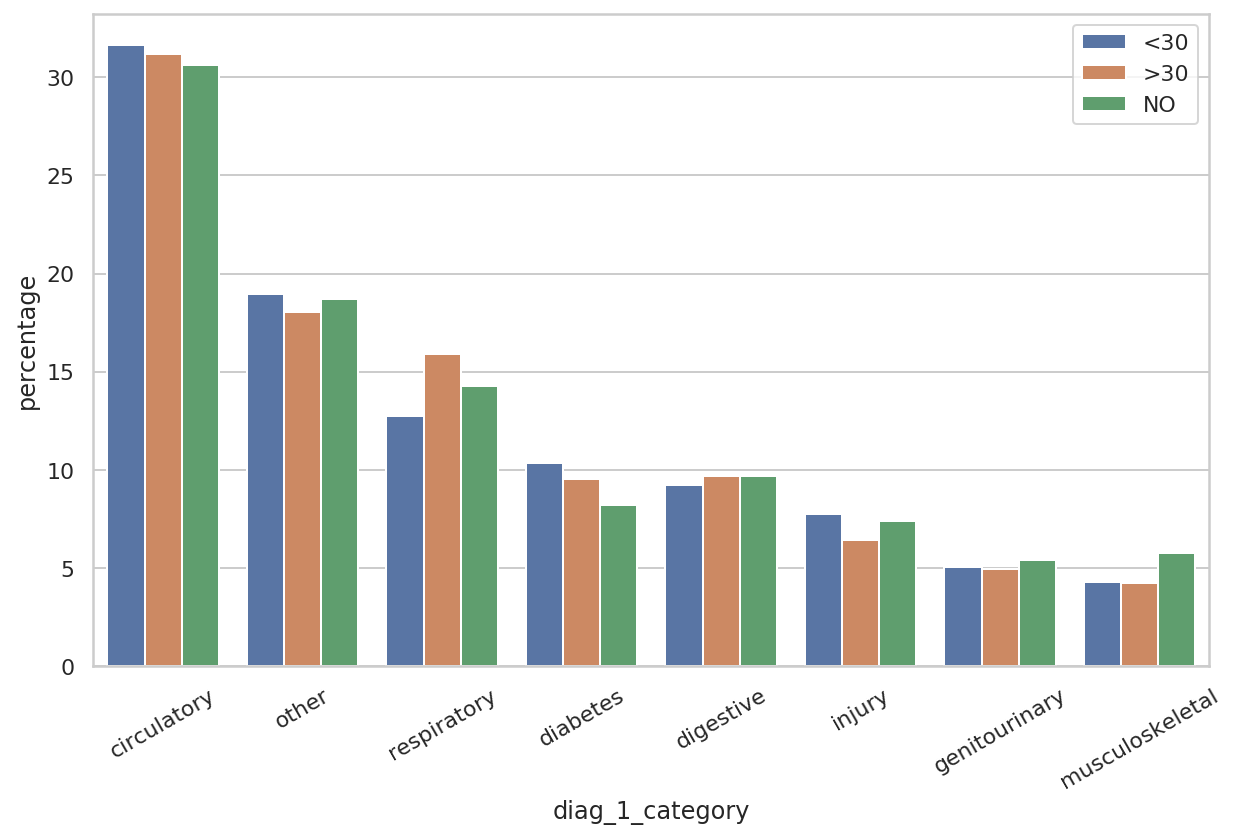

In [274]:
barplot_per_classes(df, 'diag_1_category', 'readmitted', ticks_rotation=30)

Graphs with most common codes in category groups.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


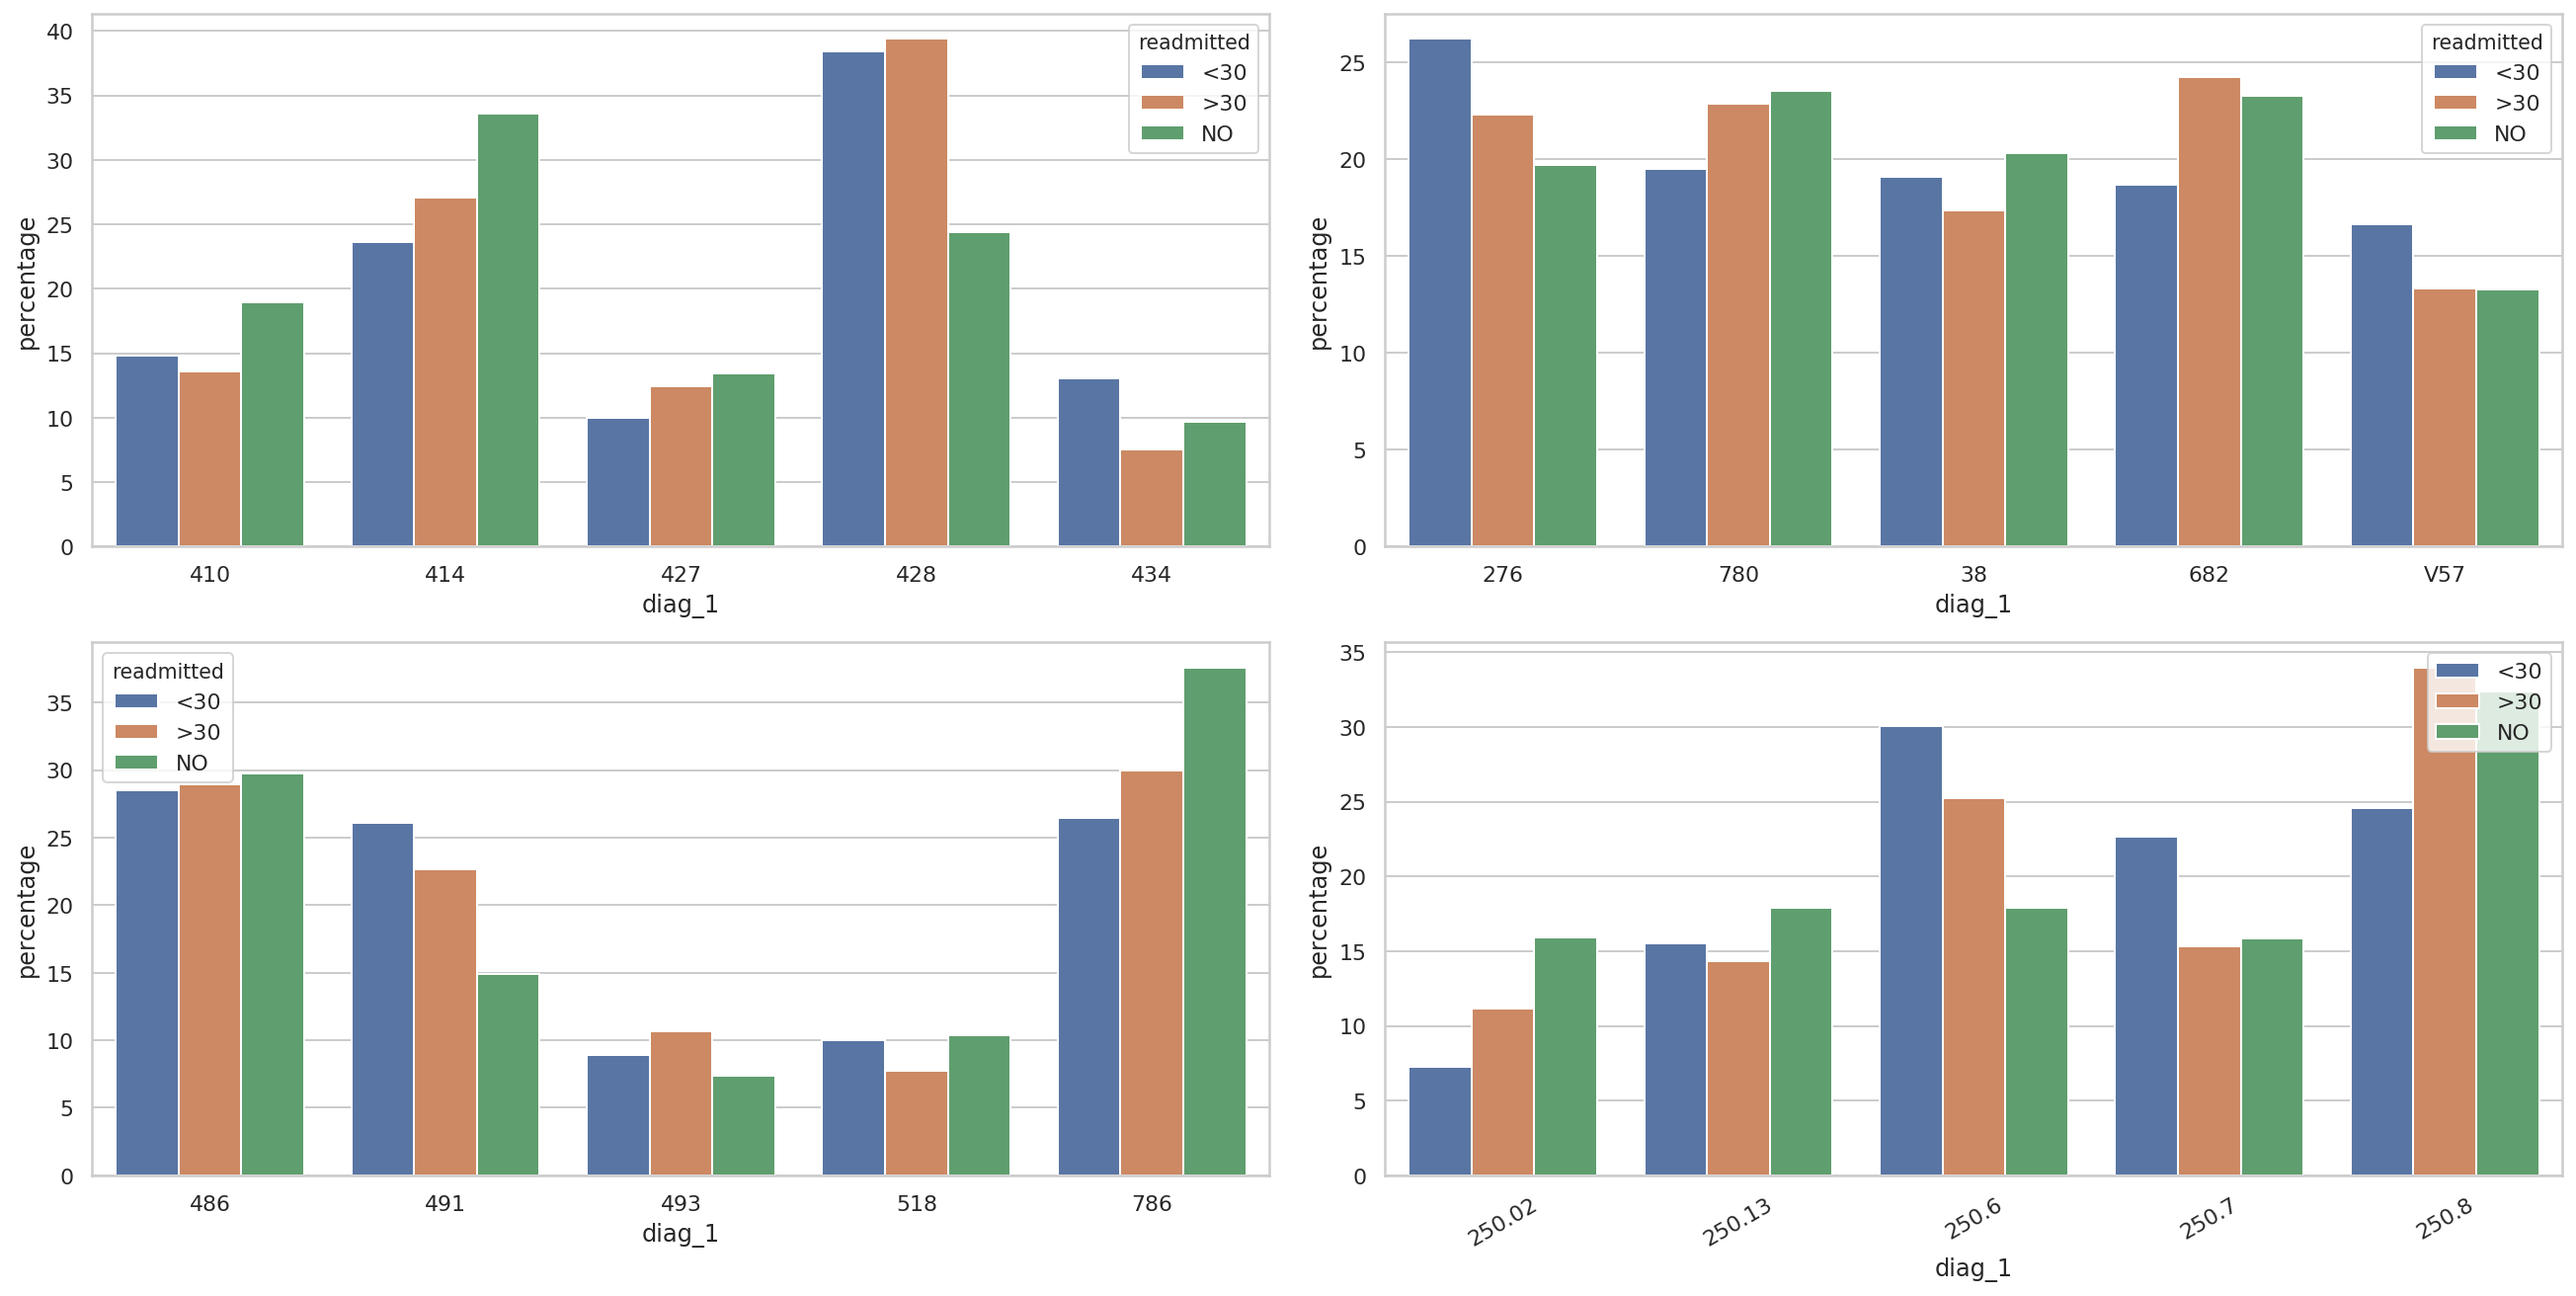

In [272]:
fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
fig.set_size_inches(18, 9)
barplot_per_classes(df[df['diag_1_category'] == 'circulatory'], 'diag_1', 'readmitted', ticks_rotation=30, topn=5, ax=axs[0][0])
barplot_per_classes(df[df['diag_1_category'] == 'other'], 'diag_1', 'readmitted', ticks_rotation=30, topn=5, ax=axs[0][1])
barplot_per_classes(df[df['diag_1_category'] == 'respiratory'], 'diag_1', 'readmitted', ticks_rotation=30, topn=5, ax=axs[1][0])
barplot_per_classes(df[df['diag_1_category'] == 'diabetes'], 'diag_1', 'readmitted', ticks_rotation=30, topn=5, ax=axs[1][1])

#### diag_2
Secondary diagnosis (coded as first three digits of ICD9); 923 distinct values

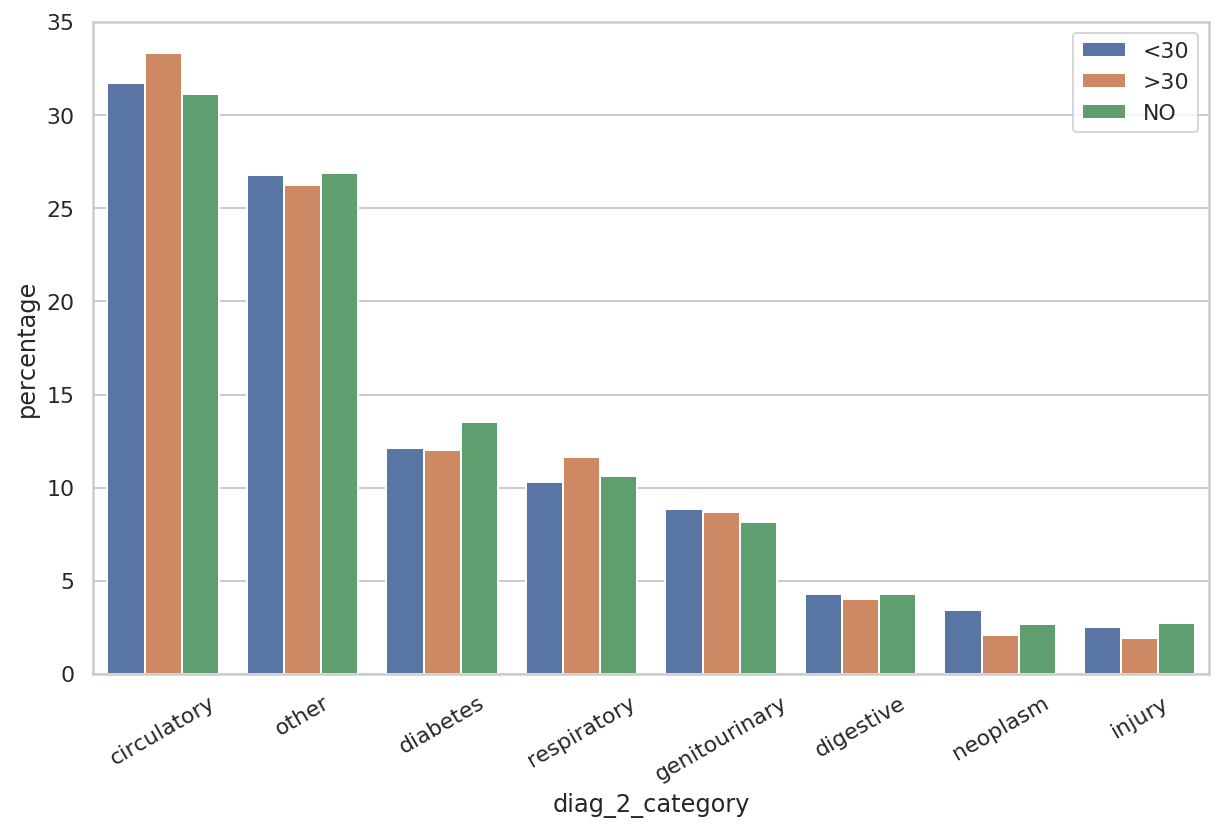

In [237]:
barplot_per_classes(df, 'diag_2_category', 'readmitted', ticks_rotation=30)

#### diag_3
Additional secondary diagnosis (coded as first three digits of ICD9); 954 distinct values

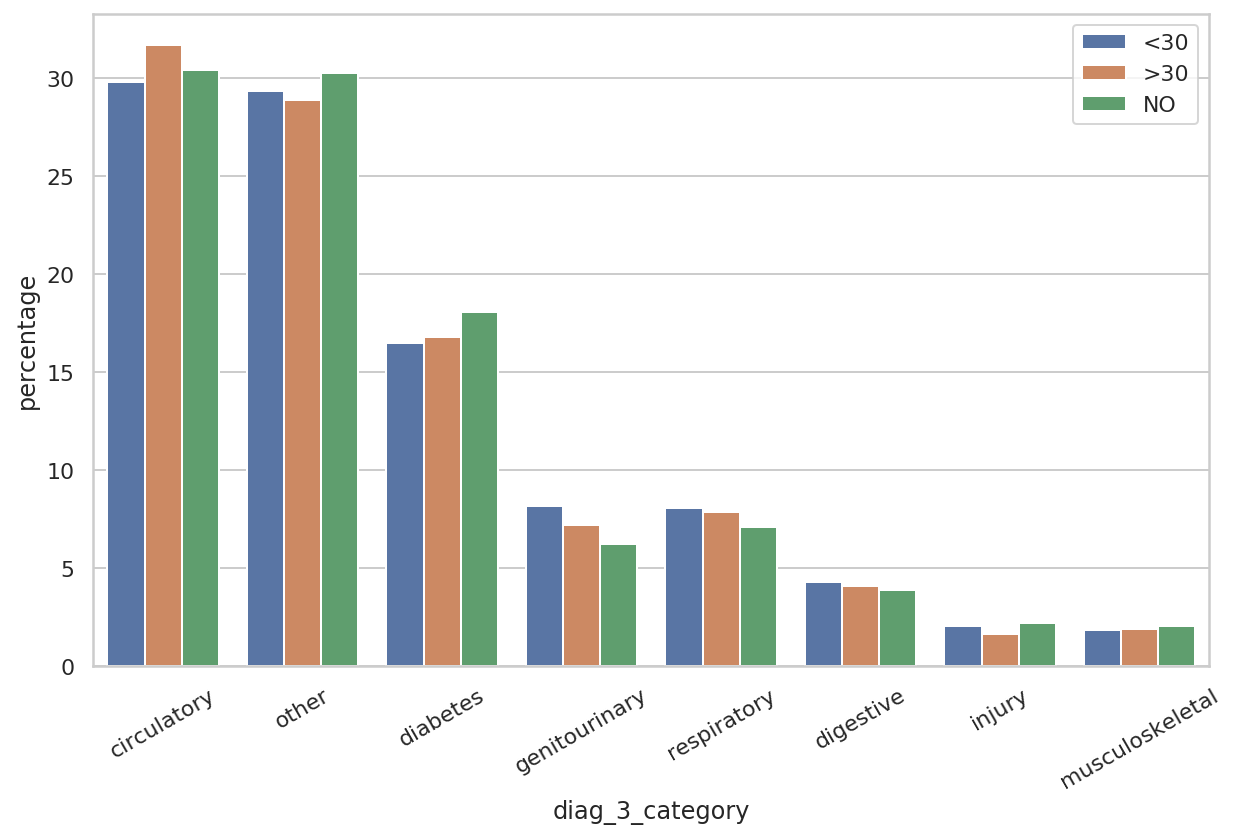

In [253]:
barplot_per_classes(df, 'diag_3_category', 'readmitted', ticks_rotation=30)